## Table of Contents

- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Exploratory Factor Analysis (EFA)](#exploratory-factor-analysis-efa)
- [Independent Component Analysis (ICA)](#independent-component-analysis-ica)
- [Conclusion](#conclusion)
- [Causal Discovery](#causal-discovery)


In [2]:
import nbformat
import re

# Load the current notebook file dynamically
notebook_path = "causal-methods.ipynb"  # Change this if needed
with open(notebook_path, "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Extract second-level (##) headings and modify them for proper HTML linking
toc_entries = []
modified_cells = []

for cell in notebook.cells:
    if cell.cell_type == "markdown":
        lines = cell.source.split("\n")
        new_lines = []
        for line in lines:
            if line.startswith("## "):  # Keep only second-level headings (##)
                title = line.strip("#").strip()
                anchor = re.sub(r"[^a-zA-Z0-9]+", "-", title.lower()).strip("-")  # Generate a valid HTML anchor
                toc_entries.append((title, anchor))
                
                # Add an HTML <h2> tag with an ID for proper linking
                new_lines.append(f'<h2 id="{anchor}">{title}</h2>')
            else:
                new_lines.append(line)
        
        # Replace the markdown content with modified headings
        cell.source = "\n".join(new_lines)
    
    modified_cells.append(cell)

# Update the notebook with modified markdown cells
notebook.cells = modified_cells

# Generate a properly formatted ToC with only `##` headings
toc_markdown = "## Table of Contents\n\n"
for title, anchor in toc_entries:
    toc_markdown += f"- [{title}](#{anchor})\n"

# Create a new Markdown cell for the ToC
toc_cell = nbformat.v4.new_markdown_cell(toc_markdown)

# Insert the Table of Contents at the top
notebook.cells.insert(0, toc_cell)

# Save the modified notebook
updated_notebook_path = "index.ipynb"
with open(updated_notebook_path, "w", encoding="utf-8") as f:
    nbformat.write(notebook, f)

print(f"Table of Contents added with only ## headings. Updated notebook saved as '{updated_notebook_path}'.")

Table of Contents added with only ## headings. Updated notebook saved as 'index.ipynb'.


<h2 id="exploratory-data-analysis">Exploratory Data Analysis</h2>

### Data Preparation

#### Check for duplicate PIDs in the dataset

In [3]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../data/w1w2w3w4w5_indices_weights_jul12_2022.csv', low_memory=False)

# Check for duplicate PIDs
duplicate_pids = df[df.duplicated('PID', keep=False)]

if not duplicate_pids.empty:
    print("There are duplicate PIDs in the dataset")
    duplicate_pids.to_csv('../data/0-duplicate_pids.csv', index=False)
    print("Duplicate PIDs have been saved to '../data/0-duplicate_pids.csv'.")
else:
    print("All PIDs are unique.")

There are duplicate PIDs in the dataset
Duplicate PIDs have been saved to '../data/0-duplicate_pids.csv'.


⬆️ here we filter the participants who participated in more than one wave and we group the responses by the PID

---
#### Filter Wave Survey Data

In [4]:
# Load the CSV file
df = pd.read_csv("../data/0-duplicate_pids.csv", low_memory=False)

# Identify valid sequences (rolling window approach)
df['valid_seq'] = df['WAVE'].rolling(3).apply(lambda x: list(x) == [2,3,4], raw=True)

# Flag rows belonging to valid sequences
df['keep'] = df['valid_seq'].shift(-2).fillna(0).astype(bool) | df['valid_seq'].shift(-1).fillna(0).astype(bool) | df['valid_seq'].fillna(0).astype(bool)

# Filter the rows
filtered_df = df[df['keep']].drop(columns=['valid_seq', 'keep'])

# Save to a new CSV file
filtered_df.to_csv("../data/1-filtered_wave_data.csv", index=False)

print("Waves 2,3,4 data saved to 1-filtered_wave_data.csv")

Waves 2,3,4 data saved to 1-filtered_wave_data.csv


⬆️ here we filter the participants who responded in waves 2 and 3 and 4 (in this order)

---
#### Likert Scale Standardization

In [5]:
# Load the CSV file from the data directory
df = pd.read_csv('../data/1-filtered_wave_data.csv', low_memory=False)

# Some variables use a five-point Likert scale (1 to 5), while others use a four-point scale (1 to 4)
# Since some scales are missing a neutral category (like 3), we need to standardize them
# We chose to rescale the 1-4 scale to match the 1-5 scale by applying a linear transformation:
# 1 (Not at all)         → 1
# 2 (Only a little)      → 2.33
# 3 (A moderate amount)  → 3.67
# 4 (A great deal)       → 5
mapping = {1: 1, 2: 2.33, 3: 3.67, 4: 5}

# List of variables to be mapped
variables_to_map = ['cc4_world', 'cc4_wealthUS', 'cc4_poorUS', 'cc4_comm', 'cc4_famheal', 'cc4_famecon']

# Apply the mapping to the specified variables
for var in variables_to_map:
    df[var] = df[var].map(mapping)

print("cc4_world, cc4_wealthUS, cc4_poorUS, cc4_comm, cc4_famheal, cc4_famecon have been transformed into a 1-5 Likert scale")

# Map pol_party variable to a 1-5 Likert scale based on pol_lean
def map_pol_party(row):
    if row['pol_party'] == 2:  # Democrat stays at 5
        return 5
    elif row['pol_party'] == 1:  # Republican stays at 1
        return 1
    elif row['pol_party'] == 3:  # Independent needs adjustment
        if row['pol_lean'] == 1:  # Leaning Republican
            return 2
        elif row['pol_lean'] == 2:  # Leaning Democrat
            return 4
        else:  # Neither, stays neutral
            return 3
    else:
        return row['pol_party']  # Keep original if unexpected value

# Apply the function
df['pol_party'] = df.apply(map_pol_party, axis=1)

print("pol_party has been transformed into a 1-5 Likert scale based on pol_lean")

# Save the cleaned data to a new CSV file
df.to_csv('../data/2-likert_scale.csv', index=False)

print("Data has been standardized and saved to 'data/likert_scale.csv'")

cc4_world, cc4_wealthUS, cc4_poorUS, cc4_comm, cc4_famheal, cc4_famecon have been transformed into a 1-5 Likert scale
pol_party has been transformed into a 1-5 Likert scale based on pol_lean
Data has been standardized and saved to 'data/likert_scale.csv'


⬆️ here we rescale the 1-4 scale and the 1-3 scale of some variables to match the 1-5 scale

---
#### Fill missing values

In [6]:
# Load the dataset
df = pd.read_csv("../data/2-likert_scale.csv", low_memory=False)

# Define policy-related columns
cc_policy_columns = ["cc_pol_tax", "cc_pol_car"]

# Fill missing values with 3 (Neutral)
for cc_policy in cc_policy_columns:
    df[cc_policy] = df[cc_policy].fillna(3)

# Save the updated dataset
df.to_csv("../data/3-missing_pol_values_filled_data.csv", index=False)

print("Missing values in policy variables filled and saved in 3-missing_pol_values_filled_data.csv")

Missing values in policy variables filled and saved in 3-missing_pol_values_filled_data.csv


In [7]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../data/3-missing_pol_values_filled_data.csv", low_memory=False)

# Define ordered WTP levels from highest to lowest
ccSolve_columns = ["ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0"]

# Function to fill missing ccSolve responses based on the one answered value
def fill_ccsolve(row):
    # Identify which ccSolve column was answered
    answered_idx = None
    answered_value = None

    for idx, col in enumerate(ccSolve_columns):
        if not pd.isna(row[col]):  
            answered_idx = idx
            answered_value = row[col]
            break  # Stop after finding the first answered column

    if answered_idx is not None:
        # Fill lower WTP levels by incrementing (+1)
        value = answered_value
        for lower_idx in range(answered_idx + 1, len(ccSolve_columns)):
            value = min(value + 1, 5)  # Cap at 5
            row[ccSolve_columns[lower_idx]] = value

        # Fill higher WTP levels by decrementing (-1)
        value = answered_value
        for higher_idx in range(answered_idx - 1, -1, -1):
            value = max(value - 1, 1)  # Floor at 1
            row[ccSolve_columns[higher_idx]] = value

    return row

# Apply the filling method
df = df.apply(fill_ccsolve, axis=1)

# Save the updated dataset
df.to_csv("../data/cleaned_data.csv", index=False)

print("ccSolve values filled using +1/-1 increments based on the single answered variable. Dataset saved as 'cleaned_data_filled.csv'.")


ccSolve values filled using +1/-1 increments based on the single answered variable. Dataset saved as 'cleaned_data_filled.csv'.


⬆️ here we fill the missing values of some variables

### Data Description

The dataset consists of variables measuring **perceptions of climate change impact, support for policies, willingness to pay (WTP) for climate policies and political affiliation and ideology**

#### Climate Change Perception Variables (`cc4_*`)
- **`cc4_world`**: Perceived extent to which global warming is harming the **world**
- **`cc4_wealthUS`**: Perceived harm of climate change on **wealthy communities** in the U.S.
- **`cc4_poorUS`**: Perceived harm of climate change on **poor communities** in the U.S.
- **`cc4_comm`**: Perceived impact of climate change on **local communities**
- **`cc4_famheal`**: Perceived impact of climate change on **family health**
- **`cc4_famecon`**: Perceived impact of climate change on **family economic well-being**

#### Willingness to Pay for Climate Policies (`ccSolve*`)
- **`ccSolve100`**: Support for climate policies if they cost **$100 per month**
- **`ccSolve50`**: Support for climate policies if they cost **$50 per month**
- **`ccSolve10`**: Support for climate policies if they cost **$10 per month**
- **`ccSolve1`**: Support for climate policies if they cost **$1 per month**
- **`ccSolve0`**: Support for climate policies **without specifying a cost**

#### Climate Policy Support (`cc_pol_*`)
- **`cc_pol_tax`**: Support for a **carbon tax** to reduce emissions
- **`cc_pol_car`**: Support for **stronger emissions standards for car manufacturers**

#### Political Affiliation and Ideology  (`pol_*`)
- **`pol_party`**: **Political party** identification (Republican, Leaning Republican, Independent, Leaning Democrat, Democrat)
- **`pol_ideology`**: **Political ideology** identification (Very Conservative, Conservative, Moderate, Liberal, Very Liberal)

### Data Summary

In [8]:
from skimpy import skim  # Equivalent to skimr::skim() in R

# Load your dataset (replace 'your_data.csv' with your actual file)
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select only the relevant numeric variables
columns_of_interest = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"
]

df_selected = df[columns_of_interest]

# Drop non-numeric columns (if any) and check correlations
df_numeric = df_selected.select_dtypes(include=['number'])

# Display summary statistics (equivalent to skimr::skim())
skim(df_numeric)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5667   │ │ float64     │ 13    │                                                          │
│ │ Number of columns │ 15     │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA   ┃ NA %   ┃ mean    ┃ sd        ┃ p0  ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ cc4_world         │    0 │      0 │   3.628 │     1.326 │   1 │   2.33 │   3.67 │      5 │     5 │ ▂▅  ▇▇  │  │
│ │ cc4_wealthUS      │    0 │      0 │   2.781 │     1.347 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▆▇  ▆▃  │  │
│ │ cc4_poorUS        │    0 │      0 │   3.396 │     1.405 │   1 │   2.33 │   3.67 │      5 │     5 │ ▃▅  ▇▇  │  │
│ │ cc4_comm          │    0 │      0 │   2.952 │     1.318 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▅▇  ▇▅  │  │
│ │ cc4_famheal       │    0 │      0 │   2.682 │     1.347 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▇  ▆▃  │  │
│ │ cc4_famecon       │    0 │      0 │   2.278 │     1.362 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▅  ▃▂  │  │
│ │ ccSolve100        │    0 │      0 │   1.623 │    0.9582 │   1 │      1 │      1 │      2 │     5 │  ▇▂ ▂▁  │  │
│ │ ccSolve50         │    0 │      0 │   2.225 │     1.245 │   1 │      1 │      2 │      3 │     5 │ ▇▅ ▃▂▁  │  │
│ │ ccSolve10         │    0 │      0 │   2.977 │     1.363 │   1 │      2 │      3 │      4 │     5 │ ▆▆ ▇▆▆  │  │
│ │ ccSolve1          │    0 │      0 │   3.723 │     1.268 │   1 │      3 │      4 │      5 │     5 │ ▂▂ ▅▅▇  │  │
│ │ ccSolve0          │    0 │      0 │   4.326 │     1.029 │   1 │      4 │      5 │      5 │     5 │  ▁ ▁▃▇  │  │
│ │ cc_pol_tax        │    0 │      0 │   3.193 │     1.311 │   1 │      2 │      3 │      4 │     5 │ ▅▃ ▇▇▅  │  │
│ │ cc_pol_car        │    0 │      0 │   3.713 │     1.229 │   1 │      3 │      4 │      5 │     5 │ ▂▂ ▆▇▇  │  │
│ │ pol_party         │    0 │      0 │   3.172 │      1.69 │   1 │      1 │      3 │      5 │     5 │ ▆▁ ▃▂▇  │  │
│ │ pol_ideology      │    0 │      0 │   2.887 │     1.068 │   1 │      2 │      3 │      3 │     5 │ ▂▃ ▇▃▂  │  │
│ └───────────────────┴──────┴────────┴─────────┴───────────┴─────┴────────┴────────┴────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### Summary Statistics
Each variable is described with:
- **Mean:** The average value
- **SD (Standard Deviation):** How spread out responses are
- **Min (p0) / Max (p100):** The range of responses
- **Quartiles (p25, p50, p75):** Percentiles of the distribution
- **Histogram:** A small visual representation of the distribution

---

#### Climate Perception Variables (`cc4_*`)
These variables measure **how much individuals believe climate change is affecting different groups and aspects of life**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|----------|---------|---------|--------------|------------------|--------------|---------|------------------|
| **`cc4_world`**    | `3.63`   | `1.33`  | `1`     | `2.33`       | `3.67`           | `5`          | `5`     | ▂▅  ▇▇        |
| **`cc4_wealthUS`** | `2.78`   | `1.35`  | `1`     | `2.33`       | `2.33`           | `3.67`       | `5`     | ▆▇  ▆▃        |
| **`cc4_poorUS`**   | `3.39`   | `1.41`  | `1`     | `2.33`       | `3.67`           | `5`          | `5`     | ▃▅  ▇▇        |
| **`cc4_comm`**     | `2.95`   | `1.32`  | `1`     | `2.33`       | `2.33`           | `3.67`       | `5`     | ▅▇  ▇▅        |
| **`cc4_famheal`**  | `2.68`   | `1.35`  | `1`     | `1.00`       | `2.33`           | `3.67`       | `5`     | ▇▇  ▆▃        |
| **`cc4_famecon`**  | `2.28`   | `1.36`  | `1`     | `1.00`       | `2.33`           | `3.67`       | `5`     | ▇▅  ▃▂        |

##### Key Insights  
- **Most respondents believe climate change is harmful**, but there is some variation in perceived impact  
- **People believe climate change affects poor communities more (`cc4_poorUS = 3.39`) than wealthy ones (`cc4_wealthUS = 2.78`)**  
- **The highest concern is for global impact (`cc4_world = 3.63`)**  
- **Community-level impact (`cc4_comm = 2.95`) is rated higher than individual family concerns** (`cc4_famheal = 2.68` and `cc4_famecon = 2.28`)  
- **Economic concerns for families economic well being (cc4_famecon = 2.28) are the least concerning**, with more responses clustered at the lower end of the scale  

---

#### Willingness to Pay for Climate Policies (`ccSolve*`)
These variables assess **how much financial support people are willing to contribute to climate policies**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|----------|---------|---------|--------------|------------------|--------------|---------|------------------|
| **`ccSolve100`**   | `1.62`   | `0.96`  | `1`     | `1.00`       | `1.00`           | `2.00`       | `5`     | ▇▂ ▂▁          |
| **`ccSolve50`**    | `2.23`   | `1.25`  | `1`     | `1.00`       | `2.00`           | `3.00`       | `5`     | ▇▅ ▃▂▁        |
| **`ccSolve10`**    | `2.98`   | `1.36`  | `1`     | `2.00`       | `3.00`           | `4.00`       | `5`     | ▆▆ ▇▆▆       |
| **`ccSolve1`**     | `3.72`   | `1.27`  | `1`     | `3.00`       | `4.00`           | `5.00`       | `5`     | ▂▂ ▅▅▇       |
| **`ccSolve0`**     | `4.33`   | `1.03`  | `1`     | `4.00`       | `5.00`           | `5.00`       | `5`     | ▁ ▁▃▇            |

##### Key Insights
- **Higher willingness to pay for lower amounts:**  
  - When asked about **paying 100 (ccSolve100)** per month, most respondents **declined** (median = `1`, meaning they are unwilling to pay)  
  - As the proposed amount **decreases**, willingness to pay **increases**, with **more people agreeing to pay smaller amounts (`ccSolve0 = 4.33`)**
- **Tipping point is between 10 and 50:**  
  - The **median willingness jumps** from `2` at `ccSolve50` to `3` at `ccSolve10`, suggesting that around **10 per month is a more acceptable threshold for most respondents**
- **Most respondents are willing to pay at least a small amount:**  
  - By the time the question reaches **$0 (ccSolve0)**, the median is `5`, meaning that **nearly everyone** is comfortable with contributing a very small amount

---

#### Climate Policy Support (`cc_pol_*`)
These variables capture **support for climate-related regulations and policies**

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|----------|---------|---------|--------------|------------------|--------------|---------|------------------|
| **`cc_pol_tax`**   | `3.19`   | `1.31`  | `1`     | `2.00`       | `3.00`           | `4.00`       | `5`     | ▅▃ ▇▇▅       |
| **`cc_pol_car`**   | `3.71`   | `1.23`  | `1`     | `3.00`       | `4.00`           | `5.00`       | `5`     | ▂▂ ▆▇▇       |

##### Key Insights
- **Higher support for car-related policies (`cc_pol_car = 3.71`) than for climate taxes (`cc_pol_tax = 3.19`)**  
  - People are more willing to **accept stronger emissions standards for car manufacturers** than supporting a **carbon tax** to reduce emissions**  
- **The median support is `3` for taxes and `4` for car policies**, showing **greater public agreement on car restrictions**  
- **Carbon tax support is more polarized (`cc_pol_tax` has a wider spread), while car restrictions (`cc_pol_car`) have more respondents at the higher end (`4-5`)**  

---

#### Political Identity (`pol_*`)
These variables measure **political party identification and ideological orientation** of respondents.

| Variable           | **Mean** | **SD**  | **Min** | **Q1 (25%)** | **Median (50%)** | **Q3 (75%)** | **Max** | **Distribution** |
|--------------------|----------|---------|---------|--------------|------------------|--------------|---------|------------------|
| **`pol_party`**    | `3.17`   | `1.69`  | `1`     | `1.00`       | `3.00`           | `5.00`       | `5`     | ▆▁ ▃▂▇        |
| **`pol_ideology`** | `2.89`   | `1.07`  | `1`     | `2.00`       | `3.00`           | `3.00`       | `5`     | ▂▃ ▇▃▂       |

##### Key Insights
- **Political party preference (`pol_party = 3.17`) has a broader spread**, meaning respondents are distributed across the scale with no clear majority  
  - **25% of respondents are at the lowest level (`Q1 = 1`)**, and **another 25% are at the highest (`Q3 = 5`)**, showing **polarization**  
- **Political ideology (`pol_ideology = 2.89`) is more centered around the middle (`median = 3`)**, suggesting **less extreme responses** compared to political party affiliation  
- **Party affiliation is more variable (`SD = 1.69`) than ideology (`SD = 1.07`)**, indicating **more diversity in party choices than in ideological leanings**  

---

#### Overall Key Insights
- **Climate change perception is generally high, especially on global impact**  
- **Support for climate policy depends on financial cost** — higher costs reduce support  
- **Regulatory measures (e.g., emissions standards) receive more support than economic measures (e.g., carbon tax)**  
- **People may strongly identify with a political party**, but their personal political views are often less extreme than their party affiliation suggests  

### Numerical Data Distribution

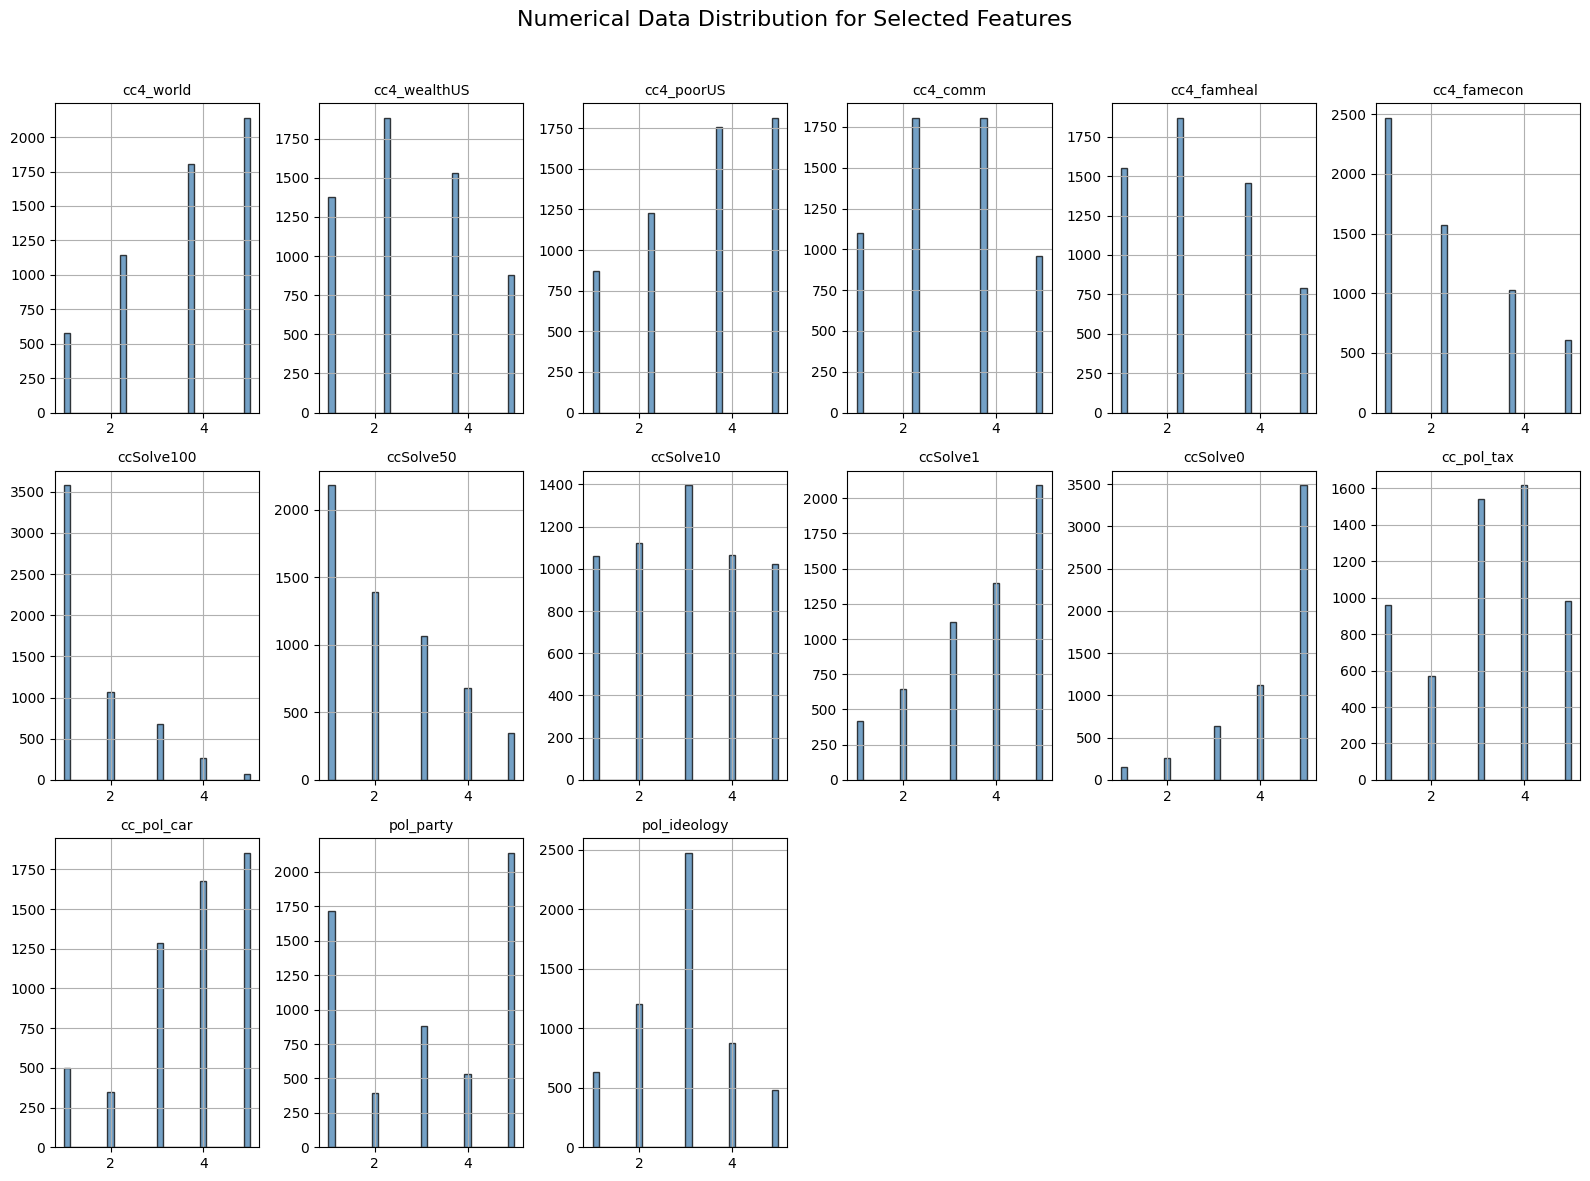

In [9]:
import matplotlib.pyplot as plt

# Select only numerical columns
df_num = df[columns_of_interest]

# Plot histograms for numerical columns with improved layout
num_cols = len(df_num.columns)
nrows = (num_cols // 6) + (num_cols % 6 > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    df_num[col].hist(ax=axes[i], bins=30, alpha=0.75, color="steelblue", edgecolor="black")
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numerical Data Distribution for Selected Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Key Observations
1. **Categorical-Like Distribution:**
   - Most variables have **discrete values (1 to 5)**, because we standardized them to 1-5 Likert scale responses
   - Some variables show **skewed distributions**, suggesting **strong opinions** in one direction
2. **Support for Climate Policies (`ccSolve*` variables)**
   - **`ccSolve100`, `ccSolve50`, `ccSolve10`, `ccSolve1`, `ccSolve0`**:
     - **Higher costs (`ccSolve100`) → More disapproval (peaked at 1)**
     - **Lower costs (`ccSolve1`, `ccSolve0`) → More balanced responses** and greater willingness to contribute
     - This suggests people are **more willing to contribute when the personal cost is lower**
3. **Climate Change Perception (`cc4_*` variables)**
   - **`cc4_world`, `cc4_poorUS`, `cc4_wealthUS`**:
     - **More responses at 4-5**, showing **strong concerns about climate change**
     - Differences in perception depending on whether the impact is on **wealthy vs. poor communities**
4. **Policy Support Variables (`cc_pol_*`)**
   - **`cc_pol_tax` (carbon tax) and `cc_pol_car` (emission standards)**:
     - **Peak responses at 3-5**, meaning **moderate to strong support for environmental policies**
5. **Political Alignment and Ideology (`pol_party`, `pol_ideology`)**  
   - **`pol_party` (political affiliation) is widely distributed**, with peaks at **Republican (1), Independent (3), and Democrat (5)**  
   - **Some respondents identify as Independents (3), but many lean Republican (2) or Democrat (4)**  
   - **`pol_ideology` centers around 3 (moderate), with fewer extreme conservatives (1) or extreme liberals (5)**  

---

#### Key Insights
- **Higher costs reduce climate policy support (`ccSolve100` vs. `ccSolve1`)**  
- **People show more concern about climate change in general (`cc4_world`) than its effect on wealthier communities (`cc4_wealthUS`)**  
- **Support for policy interventions (tax, emissions) is moderate to high**  
- **Political party affiliation and ideology are related but not always identical; many respondents may identify with a party for other reasons rather than strong ideological alignment**  

### Spearman Correlation Matrix

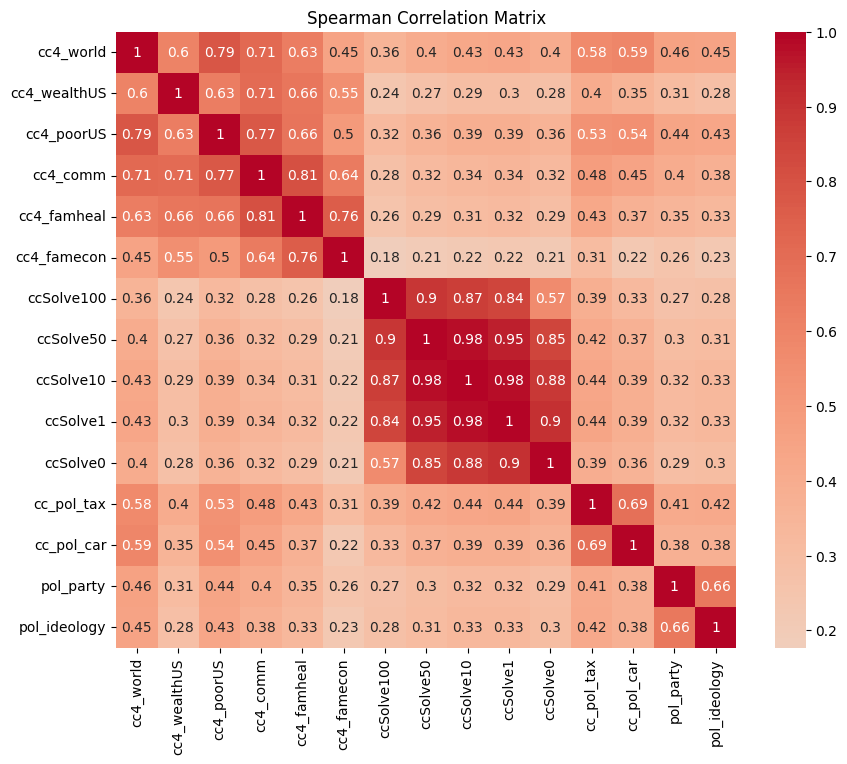

In [10]:
import seaborn as sns

# Load the cleaned CSV file from the data directory
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select the specified columns
df_selected = df[columns_of_interest]

# Calculate the Spearman correlation matrix
correlation_matrix = df_selected.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title and labels
plt.title('Spearman Correlation Matrix')
plt.show()

The correlation matrix visualizes relationships between variables using **Spearman’s Rank Correlation**. The scale ranges from **-1 (perfect negative correlation)** to **+1 (perfect positive correlation)**  (i.e., how well one variable can be described as an increasing or decreasing function of another).  

---

#### Key Observations
1. **Strong Correlations among Climate Change Perceptions (`cc4_*` variables)**  
   - **`cc4_world` (concern for climate change globally) has high correlations with `cc4_poorUS` (0.79) and `cc4_comm` (0.71)**, suggesting that those who worry about global climate change also recognize its impact on their local community and on poor communities
   - **`cc4_famheal` (climate impact on family health) has the strongest correlation with `cc4_comm` (0.81) and `cc4_famecon` (0.76)**, meaning those who believe climate change affects their family’s health also believe that it affects their local community and the economic well-being of their family

2. **Support for Climate Solutions Decreases with Higher Costs (`ccSolve*` variables)**  
   - **`ccSolve100` (willingness to support climate action at 100$ per month) has a weaker correlation with `ccSolve0` (0.57)**  
   - **Very high correlations between `ccSolve50`, `ccSolve10`, and `ccSolve1` (~0.95-0.98)** indicate that those who accept mid-range costs tend to also support lower-cost solutions  

3. **Climate Policy Support (`cc_pol_tax`, `cc_pol_car`) is positively correlated with Climate Concern**  
   - **Correlation between `cc_pol_tax` (carbon tax support) and `cc_pol_car` (emission standards regulation support) is 0.69**, meaning that people who support carbon taxes also back emissions standards
   - **`cc_pol_tax` (carbon tax support) and `cc_pol_car` (emission standards support) both correlate positively with concern for climate change impacts on a global scale** (`cc4_world`: 0.58 and 0.59 respectively) and with concern for climate impacts on poor US citizens (`cc4_poorUS`: 0.53 and 0.54 respectively)   
      - **This suggests that those who acknowledge climate change’s impact are more likely to favor policy interventions**  

4. **Political Identity (`pol_party`, `pol_ideology`) and Climate Attitudes Support**  
   - **`pol_ideology` (Conservative to Liberal scale) has a strong correlation with `pol_party` (0.66)**, confirming that political party and ideology are closely linked  
   - **`pol_party` and `pol_ideology` (Republican to Democrat scale) are positively correlated with `cc_pol_tax` (0.41, 0.42 respectively) and `cc_pol_car` (0.38, 0.38 respectively)** 

<h2 id="exploratory-factor-analysis-efa">Exploratory Factor Analysis (EFA)</h2>

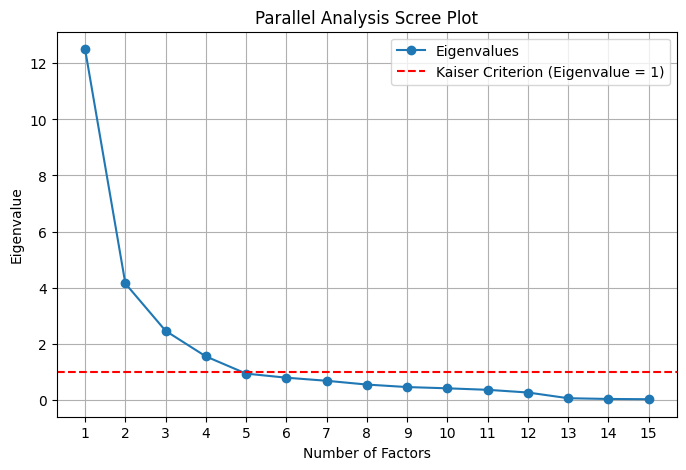

In [11]:
from sklearn.decomposition import PCA

# Load the cleaned CSV file from the data directory
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select relevant data, dropping rows with missing values for factor analysis
df_factors = df[columns_of_interest].dropna()

# Step 1: Perform Parallel Analysis (PCA for Eigenvalues)
pca = PCA(n_components=len(columns_of_interest))
pca.fit(df_factors)
eigenvalues = pca.explained_variance_

# Generate a scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker="o", linestyle="-", label="Eigenvalues")
plt.axhline(y=1, color='r', linestyle="--", label="Kaiser Criterion (Eigenvalue = 1)")
plt.title("Parallel Analysis Scree Plot")
plt.xlabel("Number of Factors")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(eigenvalues) + 1))
plt.legend()
plt.grid()
plt.show()

The scree plot suggests the optimal number of **factors/components** for analysis:
- **Kaiser Criterion (Eigenvalue > 1)** indicates that **2 to 4 factors** should be retained
- The **Elbow Rule** shows a sharp drop from **Factor 1 to 2**, then a gradual decline with a flattening around **Factor 3 or 4**
- Components beyond **Factor 4 or 5** have eigenvalues close to or below 1, meaning they explain **little variance** and may not be meaningful

In [12]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

from factor_analyzer import FactorAnalyzer

# Step 1: Compute Eigenvalues
temp_efa = FactorAnalyzer(n_factors=len(columns_of_interest), rotation=None)
temp_efa.fit(df_factors)
eigenvalues, _ = temp_efa.get_eigenvalues()

# Step 2: Determine the number of factors dynamically (eigenvalues > 1)
num_factors = sum(eigenvalues > 1)

# Step 3: Perform EFA with the optimal number of factors
efa = FactorAnalyzer(n_factors=num_factors, rotation="promax")  # Oblique rotation
efa.fit(df_factors)

# Print Factor Loadings
loadings = pd.DataFrame(efa.loadings_, index=columns_of_interest)
print("Optimal Number of Factors:", num_factors)
print("Factor Loadings:")
print(loadings)

# Print Eigenvalues to confirm factor selection
eigenvalues, _ = efa.get_eigenvalues()
print("\nEigenvalues:")
print(eigenvalues)

Optimal Number of Factors: 3
Factor Loadings:
                     0         1         2
cc4_world     0.015858  0.412046  0.520430
cc4_wealthUS -0.001180  0.740677  0.047123
cc4_poorUS   -0.020067  0.532607  0.420702
cc4_comm     -0.029770  0.833215  0.132504
cc4_famheal   0.011333  0.965335 -0.093668
cc4_famecon   0.008120  0.891973 -0.208846
ccSolve100    0.817380  0.005300 -0.052533
ccSolve50     1.006529 -0.002085 -0.080992
ccSolve10     1.031933 -0.009025 -0.036813
ccSolve1      0.908707 -0.011393  0.067252
ccSolve0      0.683088  0.007814  0.146403
cc_pol_tax    0.089282  0.052061  0.658820
cc_pol_car    0.029867 -0.000101  0.715890
pol_party    -0.039986 -0.059353  0.720496
pol_ideology -0.023471 -0.103760  0.721659

Eigenvalues:
[7.38381296 2.61378194 1.26994183 0.86794762 0.7014869  0.51380056
 0.37003823 0.35567765 0.28116621 0.22866457 0.1918385  0.1438334
 0.04591162 0.02063564 0.01146237]


#### 1️. Optimal Number of Factors
Using **Parallel Analysis and Eigenvalues > 1**, we determined that the optimal number of factors is **3**

- **Eigenvalues greater than 1** suggest that three factors explain a meaningful amount of variance
- **Scree plot analysis** confirmed this finding

#### 2️. Factor Loadings
Factor loadings indicate **how strongly each variable relates to a factor**. Higher values mean a stronger relationship.

| Variable         | **Factor 1 (Financial Support of Policies)** | **Factor 2 (Climate Impact Perception)** | **Factor 3 (Political Identity and Regulatory/Economic Policies)** |
|------------------|----------------------------------------------|------------------------------------------|--------------------------------------------------------------------|
| **cc4_world**    | 0.02                                         | **0.41**                                 | **0.52**                                                           |
| **cc4_wealthUS** | -0.00                                        | **0.74**                                 | 0.05                                                               |
| **cc4_poorUS**   | -0.02                                        | **0.53**                                 | **0.42**                                                           |
| **cc4_comm**     | -0.03                                        | **0.83**                                 | 0.13                                                               |
| **cc4_famheal**  | 0.01                                         | **0.97**                                 | -0.09                                                              |
| **cc4_famecon**  | 0.01                                         | **0.89**                                 | -0.21                                                              |
| **ccSolve100**   | **0.82**                                     | 0.01                                     | -0.05                                                              |
| **ccSolve50**    | **1.01**                                     | -0.00                                    | -0.08                                                              |
| **ccSolve10**    | **1.03**                                     | -0.01                                    | -0.04                                                              |
| **ccSolve1**     | **0.91**                                     | -0.01                                    | 0.07                                                               |
| **ccSolve0**     | **0.68**                                     | 0.01                                     | 0.15                                                               |
| **cc_pol_tax**   | 0.09                                         | 0.05                                     | **0.66**                                                           |
| **cc_pol_car**   | 0.03                                         | -0.00                                    | **0.72**                                                           |
| **pol_party**    | -0.04                                        | -0.06                                    | **0.72**                                                           |
| **pol_ideology** | -0.02                                        | -0.10                                    | **0.72**                                                           |

#### 3️. Factor Interpretations
- **Factor 1: Financial Support of Policies**
  - High loadings on **ccSolve100, ccSolve50, ccSolve10, ccSolve1, and ccSolve0**
  - Represents **public willingness to financially support climate policies**
- **Factor 2: Climate Impact Perception**
  - High loadings on **cc4_world, cc4_wealthUS, cc4_poorUS, cc4_comm, cc4_famheal, and cc4_famecon**
  - Represents **perceived harm of climate change** on different aspects of society
- **Factor 3: Political Identity and Regulatory/Economic Policies**
  - High loadings on **cc_pol_tax, cc_pol_car, pol_party, and pol_ideology**
  - Represents **support for economic and regulatory policies like carbon taxes and emission standards, as well as political alignment**
  - **`pol_party` and `pol_ideology` loading onto this factor suggest that political identity is closely tied to support for economic and regulatory climate policies**  

#### 4️. Eigenvalues
- The first **three** factors have eigenvalues **> 1**, meaning they explain a significant amount of variance
- Factors beyond the **third** contribute little additional variance

#### 5️. Key Insights
- Political ideology is a significant predictor of economic and regulatory climate policy attitudes (Factor 3)  
- People differentiate between acknowledging climate impact (Factor 2) and financial support for climate policies (Factor 1)  
- Willingness to pay (`ccSolve*`) remains a standalone factor (Factor 1), indicating it is more influenced by personal cost considerations than ideology (Factor 3)  

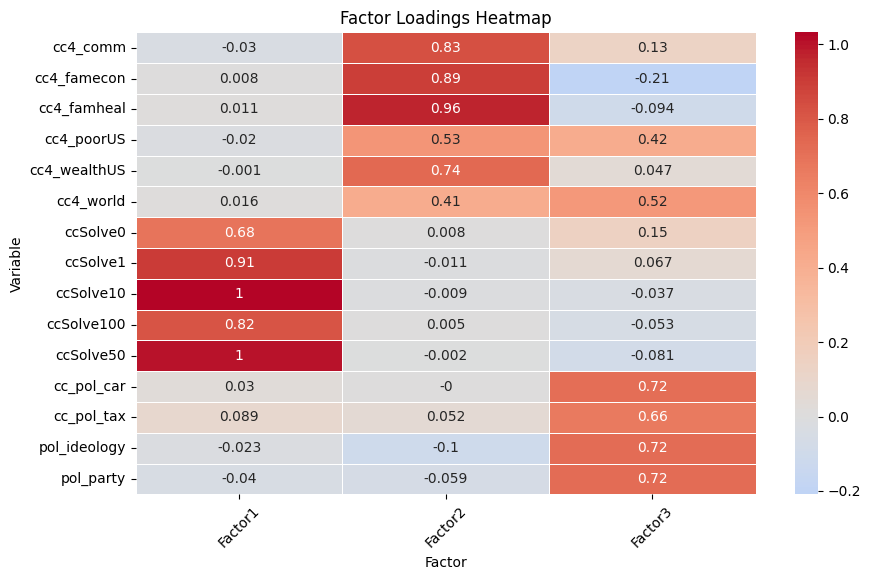

In [13]:
# Define the factor loadings dataframe
loadings = pd.DataFrame({
    "Variable": ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"],
    "Factor1": [0.016, -0.001, -0.020, -0.030, 0.011, 0.008, 0.817, 1.007, 1.032, 0.909, 0.683, 0.089, 0.030, -0.040, -0.023],
    "Factor2": [0.412, 0.741, 0.533, 0.833, 0.965, 0.892, 0.005, -0.002, -0.009, -0.011, 0.008, 0.052, -0.000, -0.059, -0.104],
    "Factor3": [0.520, 0.047, 0.421, 0.133, -0.094, -0.209, -0.053, -0.081, -0.037, 0.067, 0.146, 0.659, 0.716, 0.720, 0.722]
})

# Convert to long format for Seaborn
loadings_long = loadings.melt(id_vars=["Variable"], var_name="Factor", value_name="Loading")

# Pivot for heatmap
loadings_pivot = loadings_long.pivot(index="Variable", columns="Factor", values="Loading")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_pivot, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Formatting
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factor")
plt.ylabel("Variable")
plt.xticks(rotation=45)
plt.show()


#### 1️. Factor Loadings
Factor loadings represent **how strongly each variable is associated with the extracted factors** from our **Exploratory Factor Analysis (EFA)**

- **Factor loadings range from -1 to 1**:
  - **Closer to +1 or -1** → Strong association
  - **Closer to 0** → Weak or no association
- **The heatmap uses colors**:
  - **Red (strong positive correlation)** indicates a variable strongly contributes to a factor
  - **Blue (strong negative correlation)** suggests an inverse relationship (an inverse relationship is a situation where if one variable increases, the other tends to decrease)

---

#### 2️. Interpretation of the Factor Loadings Heatmap
The heatmap visualizes **three distinct factors** extracted from the dataset

**Factor 1: Financial Support of Policies**
- **High loadings on**: `ccSolve100 (0.82)`, `ccSolve50 (1.00)`, `ccSolve10 (1.00)`, `ccSolve1 (0.91)`, `ccSolve0 (0.68)`
- **Interpretation**: This factor captures **willingness to financially support climate policies**
- **Insight**: Respondents who support policies at high costs (`ccSolve100`) also tend to support lower-cost policies (`ccSolve1`, `ccSolve0`)

---

**Factor 2: Climate Impact Perception**
- **High loadings on**: `cc4_world (0.41)`, `cc4_wealthUS (0.74)`, `cc4_poorUS (0.53)`, `cc4_comm (0.83)`, `cc4_famheal (0.96)`, `cc4_famecon (0.89)`
- **Interpretation**: This factor represents **perceptions of climate change impact on different communities and aspects of lives**
- **Insight**: People who believe climate change affects their **family's health (`cc4_famheal`)** and **economic well-being (`cc4_famecon`)** also believe it affects **their local community (`cc4_comm`)**

---

**Factor 3: Political Identity and Regulatory/Economic Policies Support**
- **High loadings on**:
  - **Economic Policies**: `cc_pol_tax` (0.66), `cc_pol_car` (0.72)
  - **Political Identity**: `pol_party` (0.72), `pol_ideology` (0.72)
- **Interpretation**: This factor captures both **support for regulatory/economic climate policy support and political identity**
- **Insights**:
  - Political alignment (`pol_party`, `pol_ideology`) is strongly associated with climate-related tax and regulatory policies
  - People’s support for economic interventions like carbon taxes (`cc_pol_tax`) and car emissions regulations (`cc_pol_car`) is highly shaped by political ideology

### Principal Component Analysis (PCA)

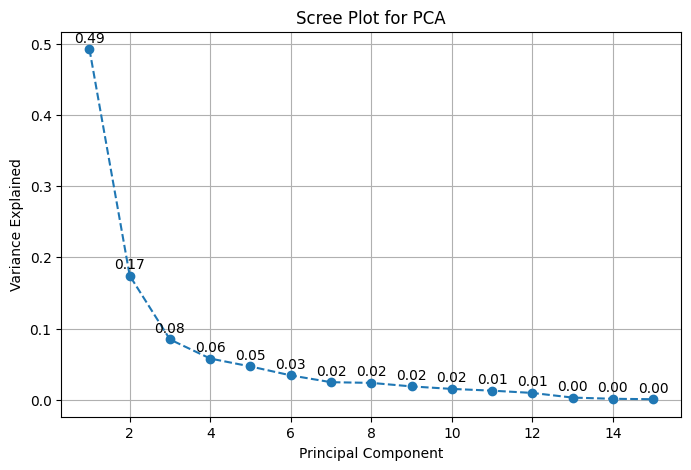

Explained Variance Ratios:
[0.4922542  0.17425213 0.08466279 0.05786317 0.04676579 0.03425337
 0.02466922 0.02371184 0.01874441 0.0152443  0.01278923 0.00958889
 0.00306077 0.00137571 0.00076416]

PCA Transformed Data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.560758  2.384463 -0.638469 -1.229989  1.458495  0.121252 -0.136529   
1 -6.255324 -0.222784 -0.892097 -0.712233 -1.738433 -0.114167  0.121506   
2 -4.843183  1.362858 -1.281958 -0.398502  0.683775  0.052583  0.162994   
3 -4.088969  0.254631  1.380014 -0.345720 -0.552130  1.028119  0.430201   
4 -1.614513  3.352181  0.438079 -0.505082  0.502111  1.045796  0.449086   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.935474 -0.280107  0.217053  0.139426 -0.043852  0.050683  0.142264   
1 -0.356519 -0.313771  0.069695  0.019650 -0.011241 -0.674854 -0.095472   
2 -0.328811 -0.388598  0.143458  0.070544 -0.058698  0.240797 -0.180033   
3  0.237981 -0.083525  0.28881

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_pca = df[columns_of_interest]

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance with labels
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
for i, var in enumerate(explained_variance):
    plt.text(i + 1, var + 0.01, f'{var:.2f}', ha='center', fontsize=10)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot for PCA')
plt.grid()
plt.show()

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(data=pca_components, columns=[f'PC{i+1}' for i in range(len(columns_of_interest))])

# Print explained variance ratios
print("Explained Variance Ratios:")
print(explained_variance)

# Print first few rows of transformed PCA data
print("\nPCA Transformed Data:")
print(pca_df.head())

#### 1️. PCA
Principal Component Analysis (PCA) helps **reduce dimensionality** while preserving as much variance as possible. Each **Principal Component (PC)** captures a percentage of the total variance in the dataset.
- **PC1 captures the most variance**, followed by PC2, PC3, and so on
- **The goal is to retain only the most meaningful components** while reducing complexity

---

#### 2️. Explained Variance Ratios
```
[0.4922542 0.17425213 0.08466279 0.05786317 0.04676579 0.03425337 0.02466922 0.02371184 0.01874441 0.0152443  0.01278923 0.00958889 0.00306077 0.00137571 0.00076416]
```
- **PC1 explains 49.22% of the total variance** (dominant component)
- **PC2 explains 17.42%**, adding substantial value
- **PC3-PC5 together contribute 18.92%**, meaning they still hold valuable information

The first 5 principal components together explain 85.56% of the total variance in the dataset. This suggests that using these five components would retain most of the important information while significantly reducing dimensionality. Beyond PC5, the rest principal components can be ignored.

**Key takeaway:** **Keeping the first 3-5 components** is optimal for balancing dimensionality reduction and retaining information

---

#### 3️. Visualizing PCA: Scree Plot
The **scree plot** helps determine how many components to retain. The **labels on each point** indicate the explained variance

- **Sharp drop after PC1 and PC2**, indicating they hold most of the variance
- **The "elbow" appears around PC3 and PC5**, suggesting these components still contribute meaningful information
- **After PC5, additional components add minimal variance**, meaning they are likely **noise** rather than useful features

**Key takeaway:** We can likely **reduce the dataset to the first 3-5 PCs without significant information loss**

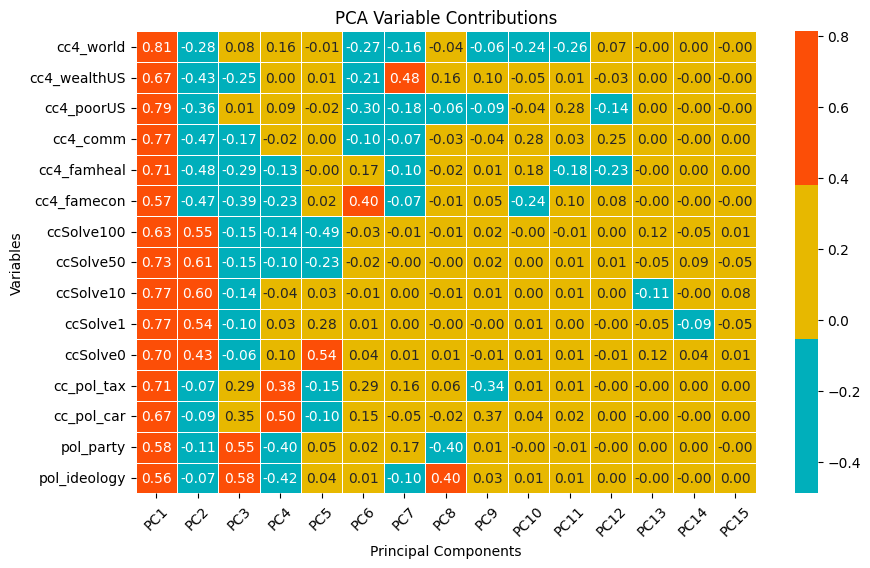

In [15]:
# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# PCA loadings (contributions of variables to PCs)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=columns_of_interest, columns=[f'PC{i+1}' for i in range(len(columns_of_interest))])

# Plot PCA variable contributions
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, cmap=["#00AFBB", "#E7B800", "#FC4E07"], annot=True, fmt=".2f", linewidths=0.5)

# Formatting
plt.title("PCA Variable Contributions")
plt.xlabel("Principal Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### PCA Variable Contributions Heatmap
This heatmap visualizes **how much each variable contributes to each Principal Component (PC)**. The values represent **loadings**, which indicate how strongly each original variable is associated with a given component

---

##### 1️. Understanding the Heatmap
- **Rows:** Represent the original variables in the dataset
- **Columns:** Represent the Principal Components (PCs)
- **Cell Values:** The **loadings**, showing how much a variable contributes to each component
- **Color Gradient:**
  - **Red/Orange (High Positive Contribution)** → Strong positive association
  - **Blue (High Negative Contribution)** → Strong negative association
  - **Yellow (~0 Contribution)** → The variable has little influence on that component

---

##### 2️. Key Observations
**PC1 (First Principal Component)**
- **High positive loadings** for `cc4_world (0.81)`, `cc4_poorUS (0.79)`, `cc4_comm (0.77)`, and `cc4_famheal (0.71)`
- **Interpretation:** PC1 is **strongly influenced by climate change perception variables (`cc4_*`)**

**PC2 (Second Principal Component)**
- **Strong contributions from** `ccSolve100 (0.55)`, `ccSolve50 (0.61)`, `ccSolve10 (0.60)`, `ccSolve1 (0.54)`
- **Interpretation:** PC2 represents **willingness to financially support climate policies (`ccSolve_*`)**

**PC3 (Third Principal Component)**
- **Higher loadings for** `cc_pol_car (0.35)`, `cc_pol_tax (0.29)`, `pol_party (0.55)` and `pol_ideology (0.58)`
- **Interpretation:** PC3 seems to represent **the political identity and regulatory/economic policies support**

---

##### 3️. Takeaways
- **Climate change perception (`cc4_*`) is the most dominant in PC1**  
- **Financial willingness to support policies (`ccSolve_*`) is captured strongly in PC2**  
- **Economic and regulatory policies (`cc_pol_*`) are closely tied to political identity (`pol_*`) in PC3**  
- **Other PCs contribute very little variance and may not be as significant**

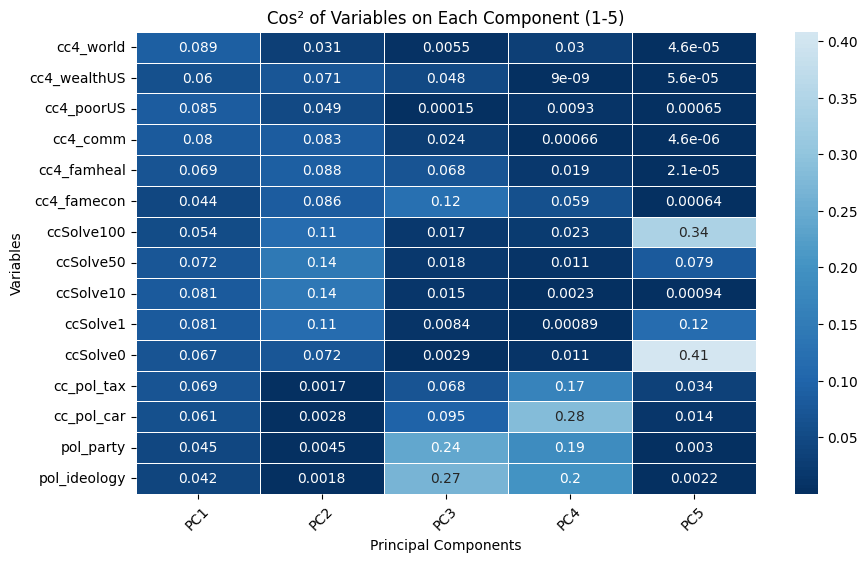

In [16]:
# Run PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Compute Cos² (squared cosine) values
loadings = pca.components_.T
cos2 = loadings**2
cos2_df = pd.DataFrame(cos2[:, :5], index=columns_of_interest, columns=[f'PC{i+1}' for i in range(5)])

# Convert to long format for heatmap
cos2_long = cos2_df.reset_index().melt(id_vars="index", var_name="Component", value_name="Cos2")

# Plot Cos² values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cos2_df, annot=True, cmap="RdBu_r", center=0.5, linewidths=0.5)

# Formatting
plt.title("Cos² of Variables on Each Component (1-5)")
plt.xlabel("Principal Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### Cos² (Squared Cosine) Heatmap
The **Cos² values** measure the **quality of representation** of each variable on the first five principal components (PCs). Higher Cos² values (closer to 1) indicate that a variable is well represented by a given principal component

---

#### 1️. Understanding Cos² Values
- **Cos² measures how well a variable is captured by a principal component**
- **Higher values (lighter blue) mean a stronger association** between the variable and the component
- **Lower values (darker blue) mean the variable is not well represented by that component**
- The sum of Cos² values across all components for a variable equals **1**

---

#### 2️. Key Observations
**PC1 (First Principal Component)**
- **Moderate representation for:** `cc4_world (0.089)`, `cc4_poorUS (0.085)`, `cc4_comm (0.08)`, `ccSolve10 (0.081)`, `ccSolve1 (0.081)`
- **Interpretation:** PC1 somewhat represents **climate change perception and financial support of climate policies**

**PC2 (Second Principal Component)**
- **Higher contributions from:** `ccSolve100 (0.11)`, `ccSolve50 (0.14)`, `ccSolve10 (0.14)`, `ccSolve1 (0.11)`
- **Interpretation:** PC2 captures **financial support of climate policies**

**PC3 (Third Principal Component)**
- **Strong representation for:** `pol_party (0.24)`, `pol_ideology (0.27)`
- **Interpretation:** PC3 represents **political identity and economic policy attitudes**

**PC4 & PC5 (Fourth and Fifth Principal Components)**
- **PC4 captures some variance from:** `cc_pol_tax (0.17)`, `cc_pol_car (0.28)`, `pol_party (0.19)`, `pol_ideology (0.2)`
- **PC5 captures some variance from:** `ccSolve100 (0.34)`, `ccSolve0 (0.41)`, `ccSolve1 (0.12)`
- **Interpretation:** PC4 and PC5 explain much less variance, meaning they are **less meaningful for capturing the dataset's structure**

---

#### 3. Takeaways
- **PC1 and PC2 are the most meaningful dimensions**, capturing perceptions of climate change and financial support for policies  
- **PC3 focuses on  political identity (`pol_*`)**  
- **Some variables are weakly represented (low Cos²), meaning they may not be strongly linked to any single component**  
- **If a variable has low Cos² across all PCs, it might not contribute significantly to the dataset’s variance**

<h2 id="independent-component-analysis-ica">Independent Component Analysis (ICA)</h2>

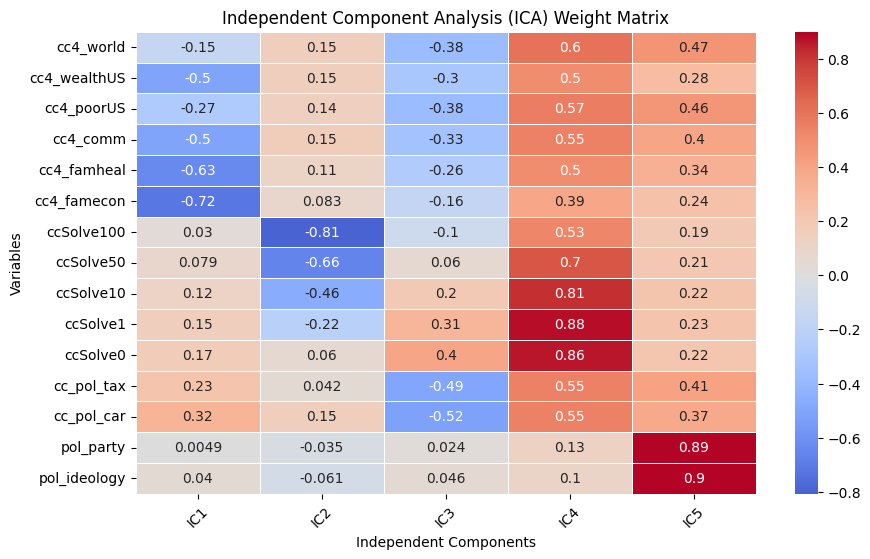

In [17]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

df_ica = df[columns_of_interest]

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_ica)

# Set the number of components to extract
n_components = 5

# Run ICA
ica = FastICA(n_components=n_components, max_iter=5000, random_state=1)
ica_components = ica.fit_transform(df_scaled)

# Extract weight matrix
weight_matrix = pd.DataFrame(ica.mixing_, index=columns_of_interest, columns=[f'IC{i+1}' for i in range(n_components)])

# Print weight matrix
# print(weight_matrix.to_string())

# Convert to long format for visualization
weight_long = weight_matrix.reset_index().melt(id_vars="index", var_name="IC", value_name="loading")

# Plot ICA weight matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(weight_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)

# Formatting
plt.title("Independent Component Analysis (ICA) Weight Matrix")
plt.xlabel("Independent Components")
plt.ylabel("Variables")
plt.xticks(rotation=45)
plt.show()

#### **Independent Component Analysis (ICA) Weight Matrix Heatmap**
This **heatmap** visualizes how **each variable contributes to each independent component (IC)** in the **ICA model**. Unlike **PCA**, ICA is designed to extract **statistically independent** sources of variation from the data

(The negative associations, `blue cells`, indicate potential trade-offs between factors, meaning people who strongly support one factor may oppose another)

---

#### 1️. Understanding the Heatmap
- **Rows:** Represent the original variables in the dataset
- **Columns:** Represent the Independent Components (IC1 to IC5)
- **Cell Values:** The **weights**, indicating the influence of a variable on an independent component
- **Color Gradient:**
  - **Red (High Positive Contribution)** → Strong positive influence of the variable on the IC
  - **Blue (High Negative Contribution)** → Strong negative influence of the variable on the IC
  - **Neutral Colors (Near 0 Values)** → Little contribution to the IC

---

#### 2️. Key Observations
**IC1 (First Independent Component)**
- **Strongest Positive Contributors:** `cc_pol_car (0.32)`, `cc_pol_tax (0.23)`, `ccSolve0 (0.17)`, `ccSolve1 (0.15)`
- **Strongest Negative Contributors:** `cc4_famecon (-0.72)`, `cc4_famheal (-0.63)`
- **Interpretation:**
  - IC1 represents **support for economic/regulatory policies, willingness to pay and family impact** `(cc4_* variables)`
  - People who score high on this component support climate relate dpolicies
  - People who score low (negative values) don't believe that climate change will affect their family

**IC2 (Second Independent Component)**
- **Strongest Postitive Contributors:** `cc4_world (0.15)`, `cc4_wealthUS (0.15)`, `cc4_comm (0.15)`, `cc4_poorUS (0.14)`
- **Strongest Negative Contributors:** `ccSolve100 (-0.81)`, `ccSolve50 (-0.66)`, `ccSolve10 (-0.46)`, `ccSolve1 (-0.22)`
- **Interpretation:**
  - IC2 strongly represents **attitudes towards climate impacts and financial support**
  - People who score high on this component consider the climate impacts
  - People who score low (negative values) don't support financial support for climate policies

**IC3 (Third Independent Component)**
- **Strongest Postitive Contributors:** `ccSolve0 (0.4)`, `ccSolve1 (0.31)`, `ccSolve10 (0.2)`
- **Strongest Negative Contributors:** `cc_pol_tax (-0.49)`, `cc_pol_car (-0.52)`
- **Interpretation:**
  - IC3 represents **willingness to pay for climate policies and support for economic/regulatory policies**
  - People who score high on this component support low-cost climate solutions
  - People who score low (negative values) don't support economic/regulatory policies

**IC4 (Fourth Independent Component)**
- **Strongest Postitive Contributors:** `ccSolve0 (0.86)`, `ccSolve1 (0.88)`, `ccSolve10 (0.81)`
- **Interpretation:**
  - IC4 represents **willingness to pay for climate policies, support for economic/regulatory policies and belief in climate change impacts**

**IC5 (Fifth Independent Component)**
- **Strongest Postitive Contributors:** `pol_ideology (0.9)`, `pol_party (0.89)`
- **Interpretation:**
  - IC4 represents **political identity**

---

#### 3️. Key Takeaways
- **IC1 represents disbelief into climate change impact(`cc4_*`)**  
- **IC2 represents unwillingness to pay for climate policies(`ccSolve*`)**  
- **IC3 represents lack of support for regulatory/economic climate policies (`cc_pol*`)**  
- **IC4 represents willingness to pay for climate policies (`ccSolve*`)**  
- **IC5 represents political identity (`pol_*`)**  

<h2 id="conclusion">Conclusion</h2>

Based on **exploratory data analysis (EDA), factor analysis (PCA & ICA), and correlation checks**, we select variables that:  
- Capture key **climate change perceptions and policy support**  
- Explain variance well in **PCA and ICA**  
- Show meaningful correlations while avoiding redundancy  

#### Climate Change Perception Variables
- `cc4_world` → Perception of climate change affecting the world **(IC4)**
- `cc4_wealthUS` → Impact of climate change on wealthy communities in the US **(IC1, IC4)**
- `cc4_poorUS` → Impact of climate change on poor communities in the US **(IC4)**
- `cc4_comm` → Impact of climate change on local communities **(IC1, IC4)**
- `cc4_famheal` → Impact of climate change on family health **(IC1, IC4)** 
- `cc4_famecon` → Impact of climate change on family economy **(IC1)**

Why Keep?  
- Strongly represented in ICA **(IC1, IC4)** and **PCA (PC1)**
- Captures different dimensions of **climate concern** in society

#### Financial Support for Climate Policies
- `ccSolve100` → Support for policies costing $100/month **(IC2, IC4)**
- `ccSolve50` → Support for policies costing $50/month **(IC2, IC4)**
- `ccSolve10` → Support for policies costing $10/month **(IC4)**
- `ccSolve1` → Support for policies costing $1/month **(IC4)**
- `ccSolve0` → Support for policies (no cost specified) **(IC4)**

Why Keep?
- Clearly separates high willingness **(IC4)** vs. reluctance **(IC2)** to pay for climate action
- **PCA (PC2)** also confirms these as distinct factors

#### Policy Support Variables
- `cc_pol_tax` → Support for a carbon tax **(IC4)**
- `cc_pol_car` → Support for stricter car emission regulations **(IC3, IC4)**

Why Keep?
- **ICA (IC3)** shows opposition to regulations
- **ICA (IC4)** shows a moderate policy support
- **PCA (PC3)** also confirms these are separate from financial contributions (`ccSolve*`)

#### Political Identity Variables
- `pol_party` → Political party identification **(IC5)**
- `pol_ideology` → Political ideology **(IC5)**

Why Keep?
- **ICA (IC5)** shows political identification
- **PCA (PC3)** shows political identity influences policy attitudes (cc_pol_tax, cc_pol_car)

<h2 id="causal-discovery">Causal Discovery</h2>

### Data Preparation and Summary

In [18]:
# Load your dataset (replace 'your_data.csv' with your actual file)
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False)

# Select only the relevant numeric variables
columns_of_interest_causal = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon",  "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1", "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"
]

df_selected = df[columns_of_interest_causal]

# Drop non-numeric columns (if any) and check correlations
df_numeric_causal = df_selected.select_dtypes(include=['number'])

# Display summary statistics (equivalent to skimr::skim())
skim(df_numeric_causal)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5667   │ │ float64     │ 13    │                                                          │
│ │ Number of columns │ 15     │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA   ┃ NA %   ┃ mean    ┃ sd        ┃ p0  ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ cc4_world         │    0 │      0 │   3.628 │     1.326 │   1 │   2.33 │   3.67 │      5 │     5 │ ▂▅  ▇▇  │  │
│ │ cc4_wealthUS      │    0 │      0 │   2.781 │     1.347 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▆▇  ▆▃  │  │
│ │ cc4_poorUS        │    0 │      0 │   3.396 │     1.405 │   1 │   2.33 │   3.67 │      5 │     5 │ ▃▅  ▇▇  │  │
│ │ cc4_comm          │    0 │      0 │   2.952 │     1.318 │   1 │   2.33 │   2.33 │   3.67 │     5 │ ▅▇  ▇▅  │  │
│ │ cc4_famheal       │    0 │      0 │   2.682 │     1.347 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▇  ▆▃  │  │
│ │ cc4_famecon       │    0 │      0 │   2.278 │     1.362 │   1 │      1 │   2.33 │   3.67 │     5 │ ▇▅  ▃▂  │  │
│ │ ccSolve100        │    0 │      0 │   1.623 │    0.9582 │   1 │      1 │      1 │      2 │     5 │  ▇▂ ▂▁  │  │
│ │ ccSolve50         │    0 │      0 │   2.225 │     1.245 │   1 │      1 │      2 │      3 │     5 │ ▇▅ ▃▂▁  │  │
│ │ ccSolve10         │    0 │      0 │   2.977 │     1.363 │   1 │      2 │      3 │      4 │     5 │ ▆▆ ▇▆▆  │  │
│ │ ccSolve1          │    0 │      0 │   3.723 │     1.268 │   1 │      3 │      4 │      5 │     5 │ ▂▂ ▅▅▇  │  │
│ │ ccSolve0          │    0 │      0 │   4.326 │     1.029 │   1 │      4 │      5 │      5 │     5 │  ▁ ▁▃▇  │  │
│ │ cc_pol_tax        │    0 │      0 │   3.193 │     1.311 │   1 │      2 │      3 │      4 │     5 │ ▅▃ ▇▇▅  │  │
│ │ cc_pol_car        │    0 │      0 │   3.713 │     1.229 │   1 │      3 │      4 │      5 │     5 │ ▂▂ ▆▇▇  │  │
│ │ pol_party         │    0 │      0 │   3.172 │      1.69 │   1 │      1 │      3 │      5 │     5 │ ▆▁ ▃▂▇  │  │
│ │ pol_ideology      │    0 │      0 │   2.887 │     1.068 │   1 │      2 │      3 │      3 │     5 │ ▂▃ ▇▃▂  │  │
│ └───────────────────┴──────┴────────┴─────────┴───────────┴─────┴────────┴────────┴────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### Spearman Correlation Matrix

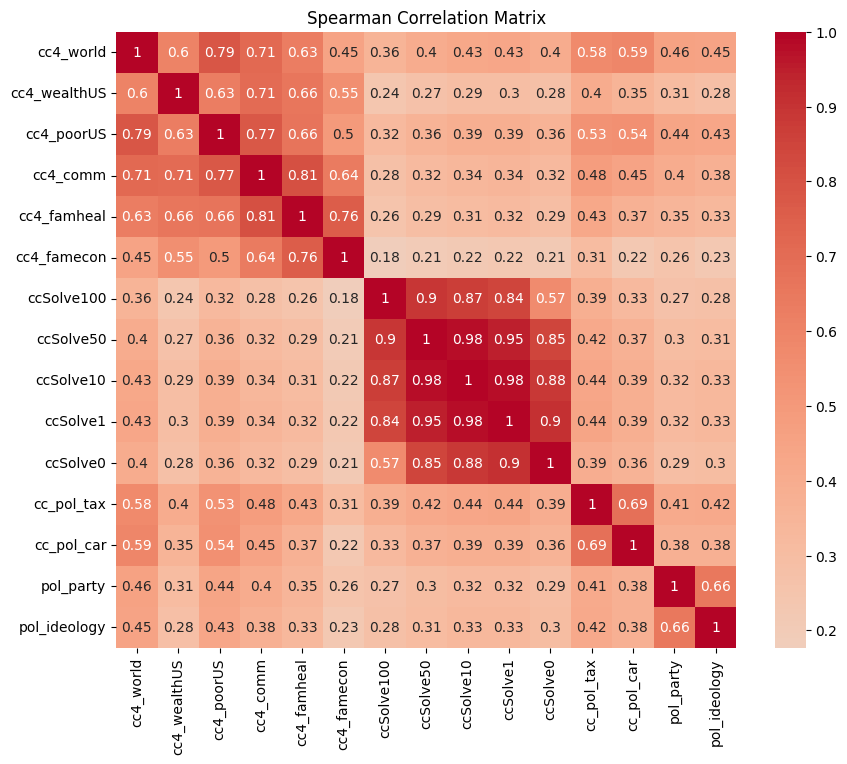

In [19]:
df_causal = df[columns_of_interest_causal]

# Compute Spearman correlation
correlation_matrix = df_causal.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title
plt.title('Spearman Correlation Matrix')
plt.show()


#### Distribution of All Variables with Density Overlay

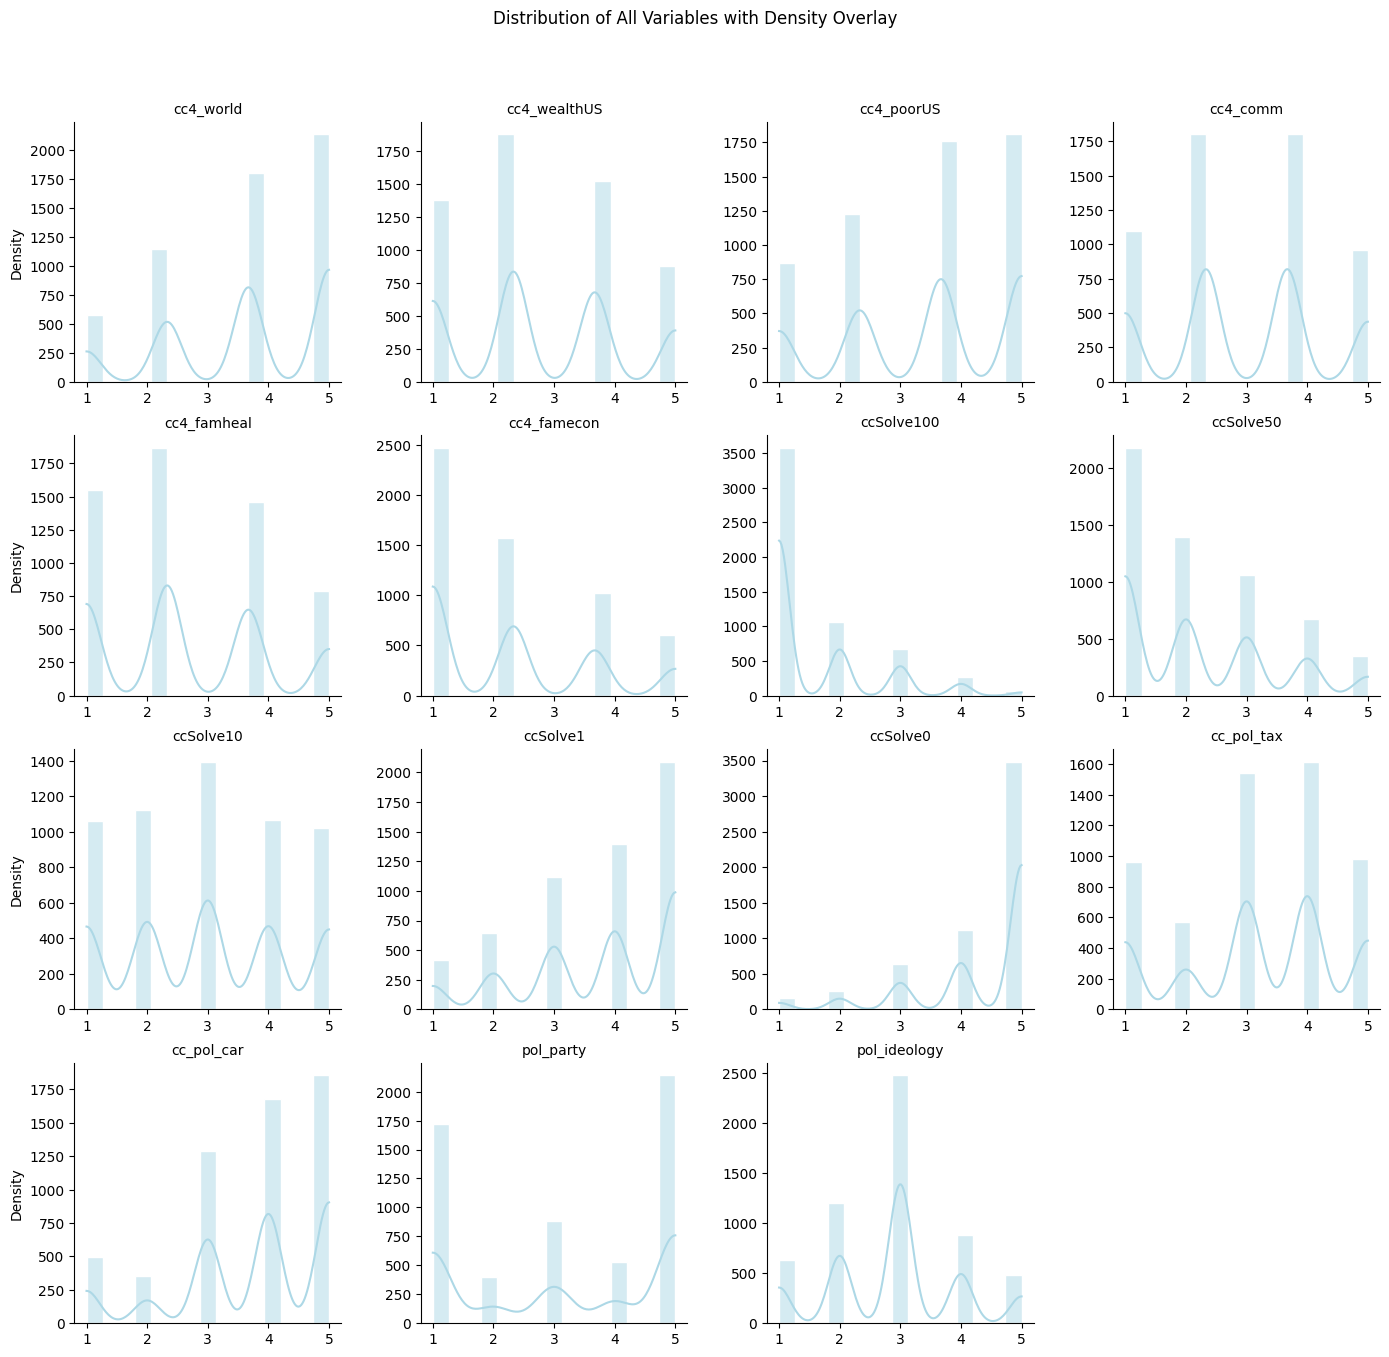

In [20]:
# Reshape data to long format for plotting
df_long = df_causal.melt(var_name="variable", value_name="value")

# Set up the FacetGrid for histogram with density overlay
g = sns.FacetGrid(df_long, col="variable", col_wrap=4, sharex=False, sharey=False, height=3.5)
g.map_dataframe(sns.histplot, x="value", bins=15, kde=True, color="lightblue", edgecolor="white")

# Adjust titles and layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Density")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of All Variables with Density Overlay")

g.set_axis_labels("", "Density")  # Remove "Value" from x-axis

# Show the plot
plt.show()


### PC

  0%|          | 0/15 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000000

0 dep 4 | () with p-value 0.000000

0 dep 5 | () with p-value 0.000000

0 dep 6 | () with p-value 0.000000

0 dep 7 | () with p-value 0.000000

0 dep 8 | () with p-value 0.000000

0 dep 9 | () with p-value 0.000000

0 dep 10 | () with p-value 0.000000

0 dep 11 | () with p-value 0.000000

0 dep 12 | () with p-value 0.000000

0 dep 13 | () with p-value 0.000000

0 dep 14 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

1 dep 4 | () with p-value 0.000000

1 dep 5 | () with p-value 0.000000

1 dep 6 | () with p-value 0.000000

1 dep 7 | () with p-value 0.000000

1 dep 8 | () with p-value 0.000000

1 dep 9 | () with p-value 0.000000

1 dep 10 | () with p-value 0.000000

1 dep 11 | () with p-value 0.000000

1 dep 12 | () with p-value 0.000000

1 dep 13 | () with p-value 0.000000

1 dep 14 | () with 

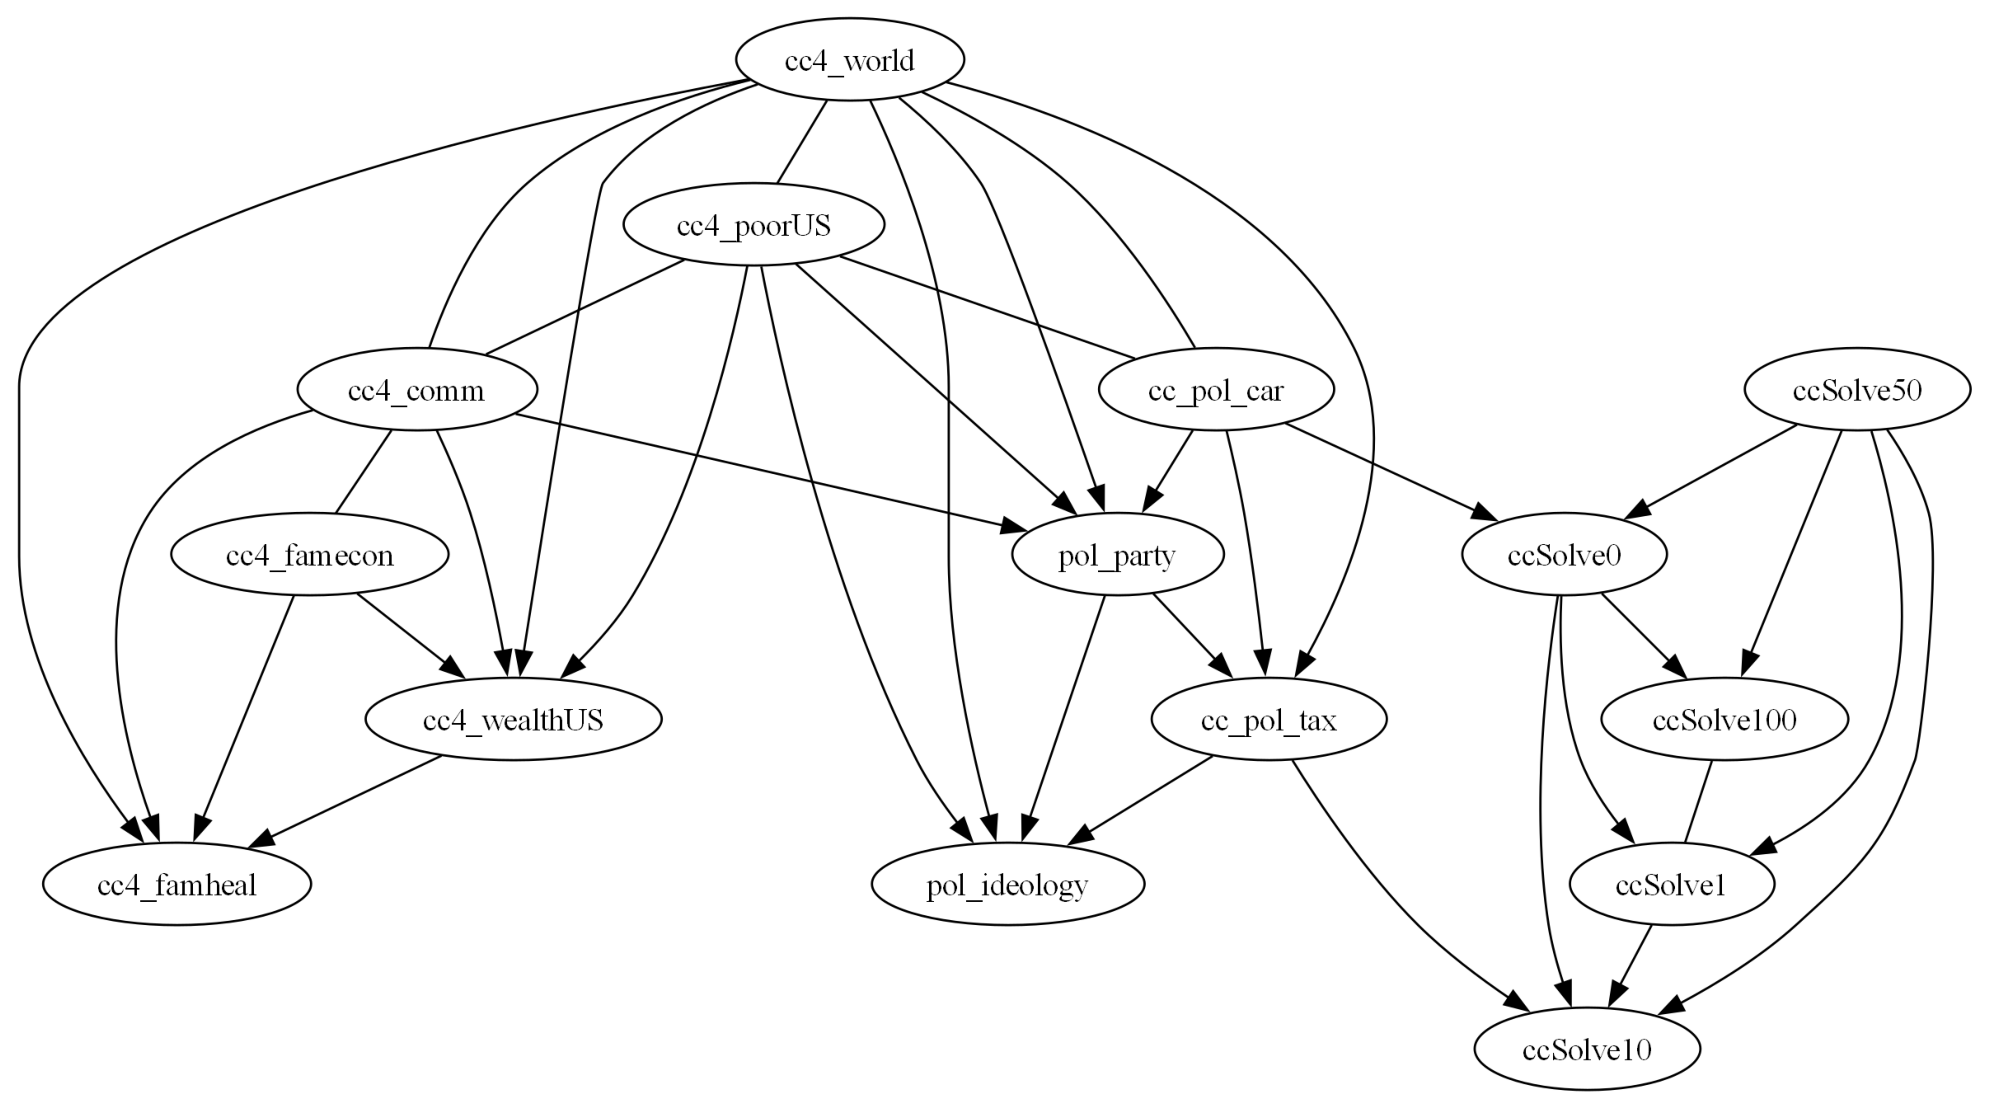

Causal graph saved as causal_graph_pc.png


In [21]:
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

# Load dataset
data = pd.read_csv("../data/cleaned_data.csv")

# Select relevant columns
columns = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal",
           "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1",
           "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"]

data = data[columns]  # Ensure we're working with the correct variables

# Convert to numpy (PC algorithm requires NumPy format)
data_np = data.to_numpy()

# Run PC algorithm
cg = pc(data_np, verbose=True)

# 🛠️ **Fix: Pass labels when visualizing**
cg.draw_pydot_graph(labels=columns)

# Save graph as an image with labels
pyd = GraphUtils.to_pydot(cg.G, labels=columns)
pyd.write_png("causal_graph_pc.png")

print("Causal graph saved as causal_graph_pc.png")

### FCI

  0%|          | 0/15 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000000

0 dep 4 | () with p-value 0.000000

0 dep 5 | () with p-value 0.000000

0 dep 6 | () with p-value 0.000000

0 dep 7 | () with p-value 0.000000

0 dep 8 | () with p-value 0.000000

0 dep 9 | () with p-value 0.000000

0 dep 10 | () with p-value 0.000000

0 dep 11 | () with p-value 0.000000

0 dep 12 | () with p-value 0.000000

0 dep 13 | () with p-value 0.000000

0 dep 14 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

1 dep 4 | () with p-value 0.000000

1 dep 5 | () with p-value 0.000000

1 dep 6 | () with p-value 0.000000

1 dep 7 | () with p-value 0.000000

1 dep 8 | () with p-value 0.000000

1 dep 9 | () with p-value 0.000000

1 dep 10 | () with p-value 0.000000

1 dep 11 | () with p-value 0.000000

1 dep 12 | () with p-value 0.000000

1 dep 13 | () with p-value 0.000000

1 dep 14 | () with 

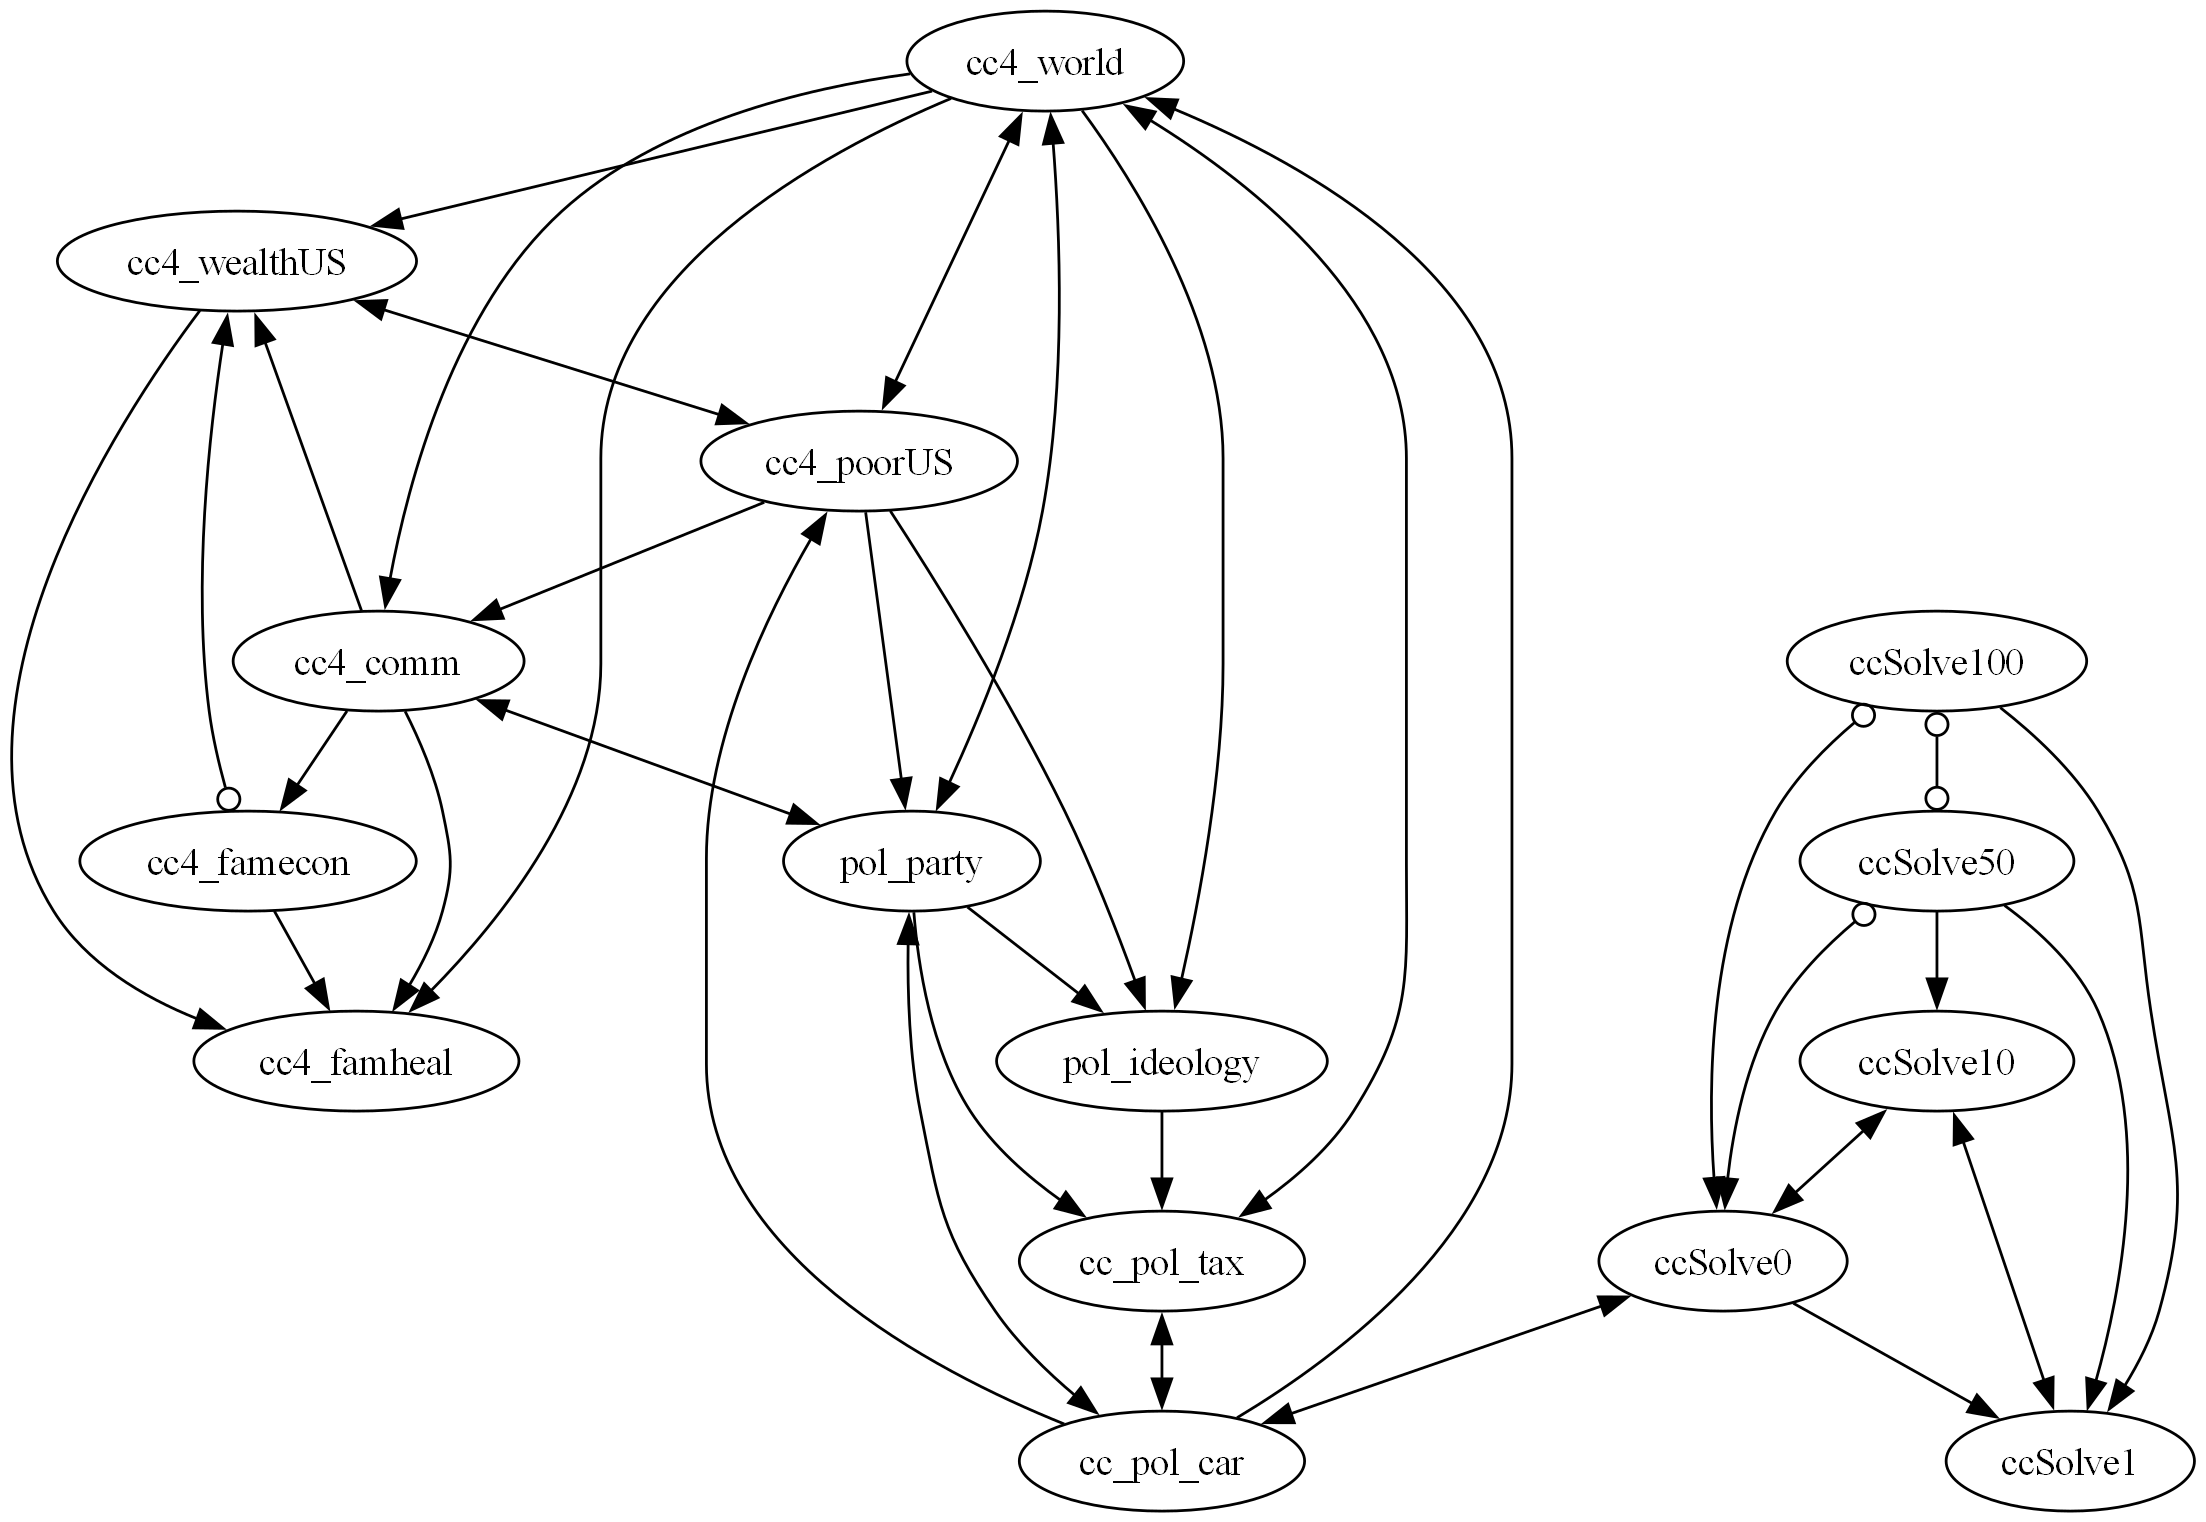

In [22]:
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
from IPython.display import Image

# Load dataset
data = pd.read_csv("../data/cleaned_data.csv")

# Select relevant columns (15 variables)
columns = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal",
           "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1",
           "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"]

data = data[columns]  # Ensure correct columns

# Convert to numpy (FCI requires NumPy array)
data_np = data.to_numpy()

# Run FCI Algorithm
g, edges = fci(data_np, independence_test_method="fisherz", alpha=0.05, verbose=True)

# 🛠 **Fix: Apply correct variable names**
pdy = GraphUtils.to_pydot(g, labels=columns)  # Pass labels

# Save graph with real variable names
pdy.write_png("fci_graph_named.png")

print("✅ FCI causal graph saved as fci_graph_named.png")

# Display graph in Jupyter Notebook
Image(filename="fci_graph_named.png")

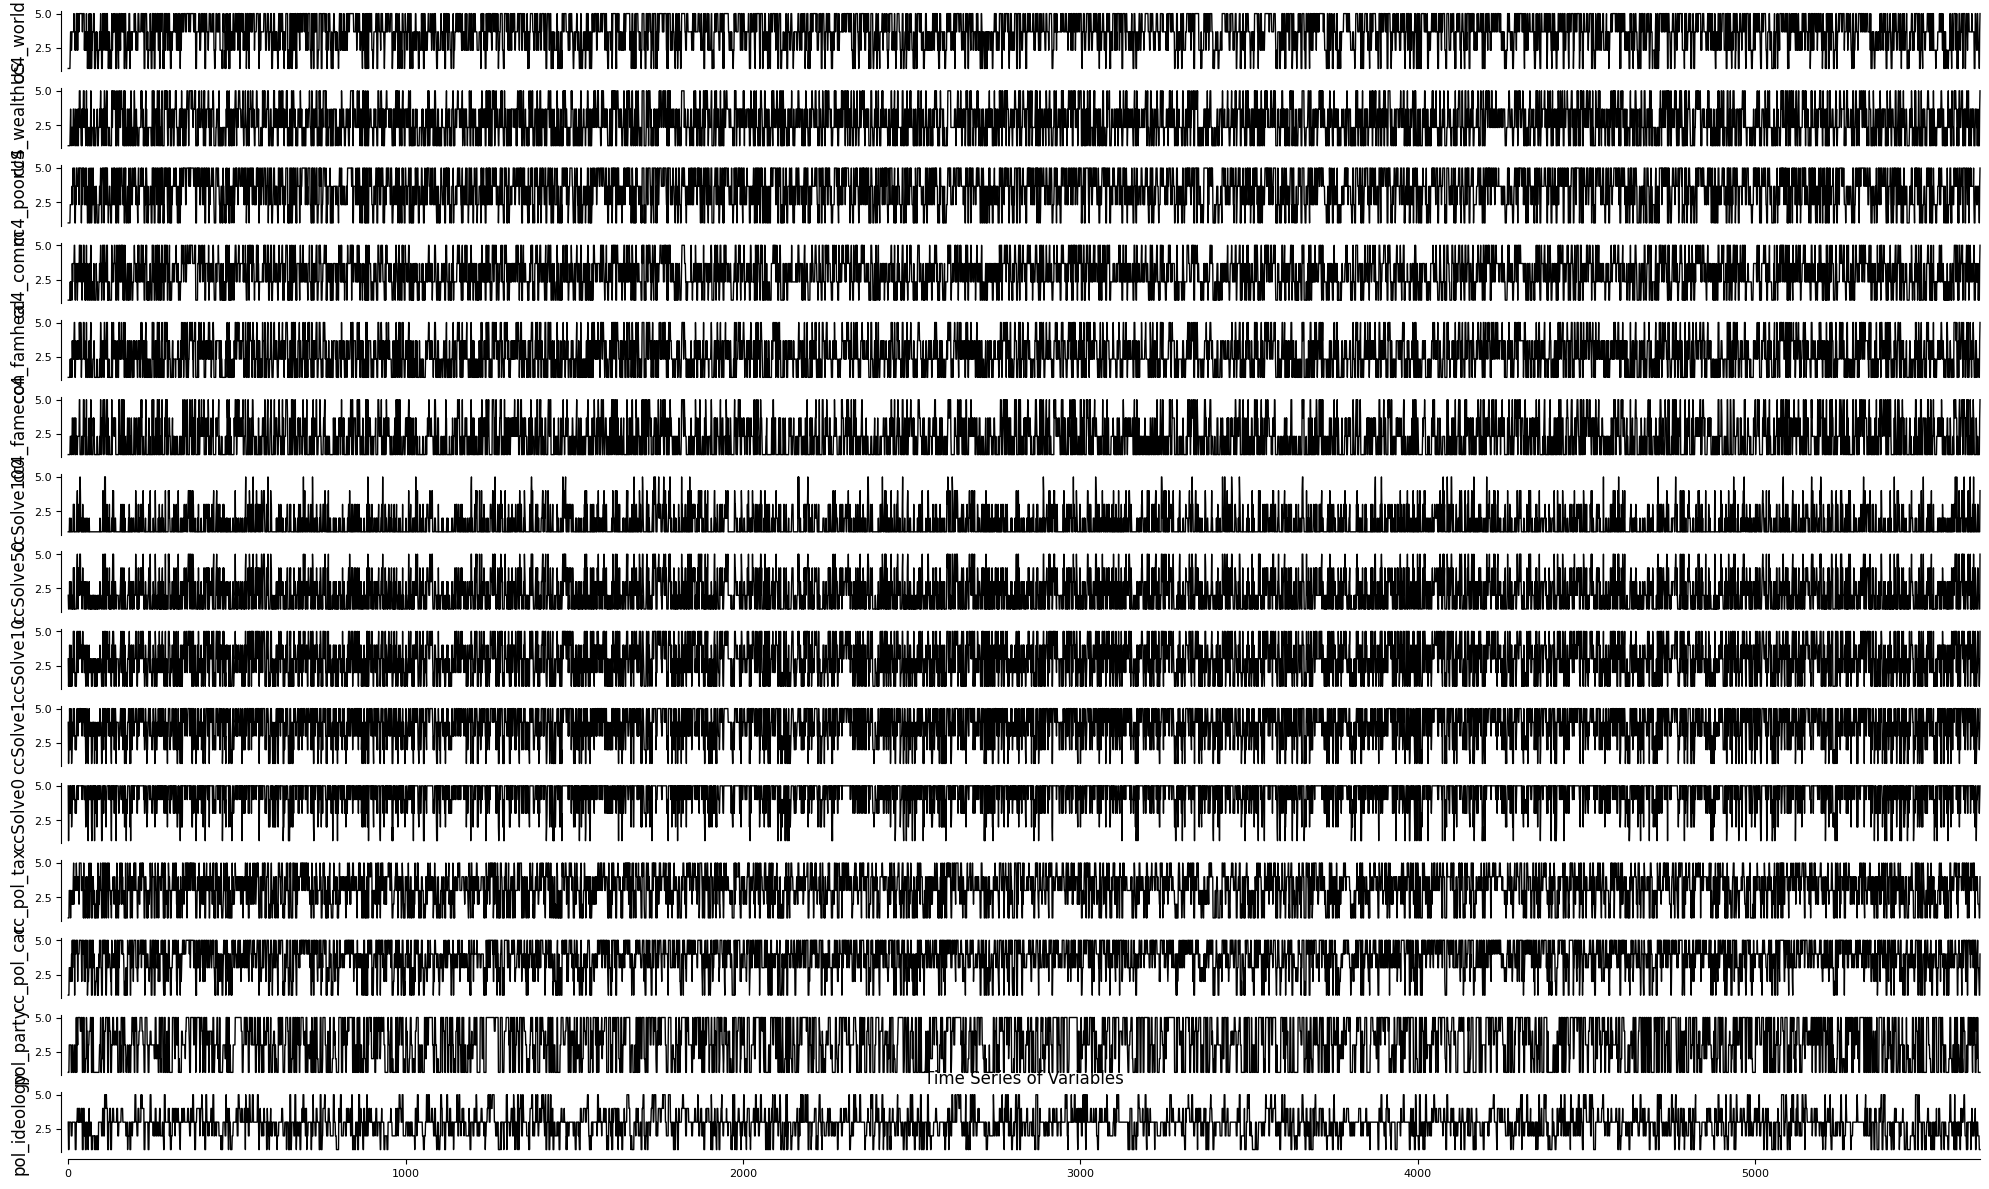

TypeError: 'module' object is not callable

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Tigramite
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr
from tigramite import plotting as tp

# Load dataset
data = pd.read_csv("../data/cleaned_data.csv")

# Select relevant columns
columns = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal",
           "cc4_famecon", "ccSolve100", "ccSolve50", "ccSolve10", "ccSolve1",
           "ccSolve0", "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"]

data = data[columns]  # Select only relevant variables

# Convert data to numpy format
data_np = data.to_numpy()

# Convert data to Tigramite's DataFrame format
dataframe = pp.DataFrame(data_np, datatime=np.arange(len(data_np)), var_names=columns)

# 🟢 **Plot Time Series**
tp.plot_timeseries(dataframe, label_fontsize=12, tick_label_size=8)
plt.title("Time Series of Variables")
plt.show()

# Run PCMCI with Partial Correlation (ParCorr) as the independence test
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr(), verbosity=1)

# Set maximum time lag for causal discovery
tau_max = 2
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=0.05)

# Print discovered causal links
print("Discovered causal links:", results['graph'])

# 🟢 **Plot Lagged Dependencies**
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
tp.plot_lagfuncs(
    val_matrix=correlations, 
    setup_args={'var_names': columns, 'x_base': 5, 'y_base': .5}
)
plt.title("Lagged Dependencies")
plt.show()

# 🟢 **Plot Causal Graph**
tp.plot_graph(
    graph=results['graph'],
    val_matrix=results['val_matrix'],
    var_names=columns,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=10,
    label_fontsize=12,
    tick_label_size=10,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.5
)
plt.title("Causal Graph (PCMCI)")
plt.show()

# 🟢 **Plot Time-Series Graph**
tp.plot_time_series_graph(
    figsize=(6, 6),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=columns,
    link_colorbar_label='MCI',
    label_fontsize=12,
    tick_label_size=12
)
plt.title("Time-Series Causal Graph")
plt.show()
